# Costa Rican Household Poverty Level Prediction

The objective of the Costa Rican Household Poverty Level Prediction contest is to develop a machine learning model that can predict the porverty level of household using both individual and household characteristics.  
  
In this notebook, we will walk through a complete machine learning solution:  
1) get introduced to the problem
2) perform a thorough Exploratory Data Analysis of the dataset, work on feature engineering, try out multiple machine learning models, select a model, work to optimize the model
3) inspect the outputs of the model and draw conclusions  

## Problem and Data Explanation

The data for this competition is provided in two files: train.csv and test.csv. The training set has 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns. Each row represents **one individual** and each column is a **feature, either unique to the individual, or for the household of the individual.** The training set has one additional column, Target, which represents the poverty level on a 1-4 scale and is the label for the competition. A value of 1 is the most extreme povety.  
  
This is a **superviesed multi-class classification machine learning problem**:
- **Supervised**: provided with the labels for the training data
- **Multi-class classification**: Labels are discrete values with 4 classes  

### Objective

The objective is to predict poverty on a household level. We are given data on the individual level with each individual having unique features but also information about their household. In order to create a dataset for the task, we'll have to perform some aggregations of the individual data for each household. Moreover, we have to make a prediction for every individual in the test set, but 'ONLY the heads of household are used in scoring' which means we want to predict poverty on a household basis.  
  
**Important note: while all members of a household should have the same label in the training data, there are errors where individuals in the same household have different labels. In these cases, we are told to use the label for the head of each household, which can be identified by the rows where parentesco1 == 1.0.** We will cover how to correct this in the notebook.  
  
The Target values represent poverty levels as follows:  
1 = extreme poverty  
2 = moderate poverty  
3 = vulneralbe households  
4 = non vulnerable households  
  
The explanations for all 143 columns can be found in the competition documentation, but a few to note are below:  
- **id**: a unique identified for each individual, this should not be a feature that we use
- **idhogar**: a unique identifier for each household. This variable is not a feature, but will be used to group individuals by household as all individuals in a household will have the same identifier
- **parentesco1**: indicates if this person is the head of the household
- **Target**: the label, which should be equal for all members in a household

When we make a model, we'll train on a household basis with the label for each household the poverty level of the head of household. The raw data contains a mix of both household and individual characteristics and for the individual data, we will have to find a way to aggregate this for each household. Some of the individuals belong to a household with no head of household which means that unfortunately we can't use this data for training. These issues with the data are completely typical of real-world data and hence this problem is great preparation for the datasets you'll encounter in a data science job.

### Metric

Ultimately we want to build a machine learning model that can predict the integer poverty level of a household. Our predictions will be assessed by the **Macro F1 Score**. You may be familiar with the standard F1 score for binary classification problems which is the harmonic mean of precision and recall:  
$$F1 = 2 \cdot {precision \cdot recall \over precision + recall}$$  

For multi-class problems, we have to average the F1 scores for each class. The macro F1 score averages the F1 score for each class without taking into account label imbalances.  
$$ Macro F1 = {F1 Class 1 + F1 Class 2 + F1 Class 3 + F1 Class 4 \over 4} $$

In other words, the number of occurrences of each label does not figure into the calculation when using macro (while it does without using the 'weighted' score). If we want to assess our performance, we can use the code:
```
from sklearn.metrics import f1_score
f1_score(y_ture, y_predicted, average='macro')
```

For this problem, the labels are imbalanced, which makes it a little strange to use macro average for the evaluation metric, but that's a decision made by the organizers and not something we can change. In your own work, you want to be aware of label imbalances and choose a metric accordingly.

## Roadmap

The end objective is a machine learning model that can predict the poverty level of a household. However, before we get carried away with modeling, it's important to understand the problem and data. Also, we want to evalute numerous models before choosing one as the 'best' and after building a model, we want to investigate the predictions. Our roadmap is therefore as follows:
1. Understand the problem (we're almost ther already)
2. Exploratory Data Analysis
3. Feature engineering to create a dataset for machine learning
4. Compare several baseline machine learning models
5. Try more complex machine learning models
6. Optimize the selected model
7. Investigate model predictions in context of problem
8. Draw conclusions and lay out next steps

The steps laid out above are iterative meaning that while we will go through them one at a time, we might go back to an earlier step and revisit some of our decisions. In general, data science is an non-linear practice where wer are constantly evaluating our past decisions and making imporvements. In particular, feature engineering, modeling, and optimization are steps that we often repeat because we never know if we got them right the first time.

# Getting Started

We have a pretty good grasp of the problem, so we'll move into the Exploratory Data Analysis (EDA) and feature engineering. For the EDA we'll examine any interesting anomalies, trends, correlations, or patterns that can be used for feature engineering and for modeling. We'll make sure to investigate our data both quantitatively (with statistics) and visually (with figures).  
  
Once we have a good grasp of the data and any potentially useful relationships, we can do some feature engineering (the most important part of the machine learning pipeline) and establish a baseline model. This won't get us to the top of the leaderboard, but it will provide a strong foundation to build on.  

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

import warnings
warnings.filterwarnings('ignore')

## Read in Data and Look at Summary Information

In [2]:
pd.options.display.max_columns = 150

# read in data
train = pd.read_csv('./costa-rican-household-poverty-prediction/train.csv')
test = pd.read_csv('./costa-rican-household-poverty-prediction/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


That gives us a look at all of the columns which don't appear to be in any order.  
To get a quick overview of the data we use df.info()

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


This tells us there are 130 integer columns, 8 float (numeric) columns, and 5 object columns. The integer columns probably represent Boolean variables (that take on either 0 or 1) or ordinal variables with discrete oredered values. The object columns might pose an issue because they cannot be fed directly into a machine learning model.  
  
Let's glance at the test data which has many more rows (individuals) than the train. It does have one fewer column because there's no Target.

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


### Integer Columns

Let's look at the distribution of unique values in the integer columns. For each column, we'll count the number of unique values and show the result in a bar plot.

Text(0.5, 1.0, 'Count of Unique Values in Integer Columns')

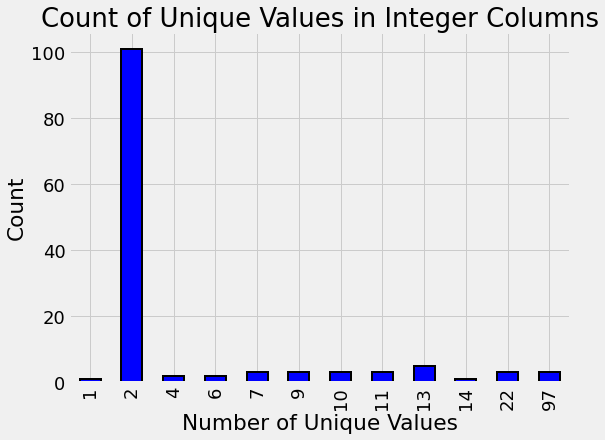

In [5]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='blue', figsize=(8, 6), edgecolor='k', linewidth=2)
plt.xlabel('Number of Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values in Integer Columns')

The columns with only 2 unique values represent Booleans (0 or 1). In a lot of cases, this boolean information is already on a household level. For example, the refrig column says whether or not the household has a refrigerator. When it comes time to make features from the Boolean columns that are on the household level, we will not need to aggregate these. However, the Boolean columns that are on the individual level will need to be aggregated.

### Float Columns

Another column type is floats which represent continuous variables. We can make a quick distribution plot to show the distribution of all float columns. We'll use an OrderedDict to map the poverty levels to colors because this keeps the keys and values in the same order as we specify (unlike a regular Python dictionary).  
  
The following graphs shows the distributions of the float columns colored by the value of the Target. With these plots, we can see if there is a significant difference in the variable distribution depending on the household poverty level.

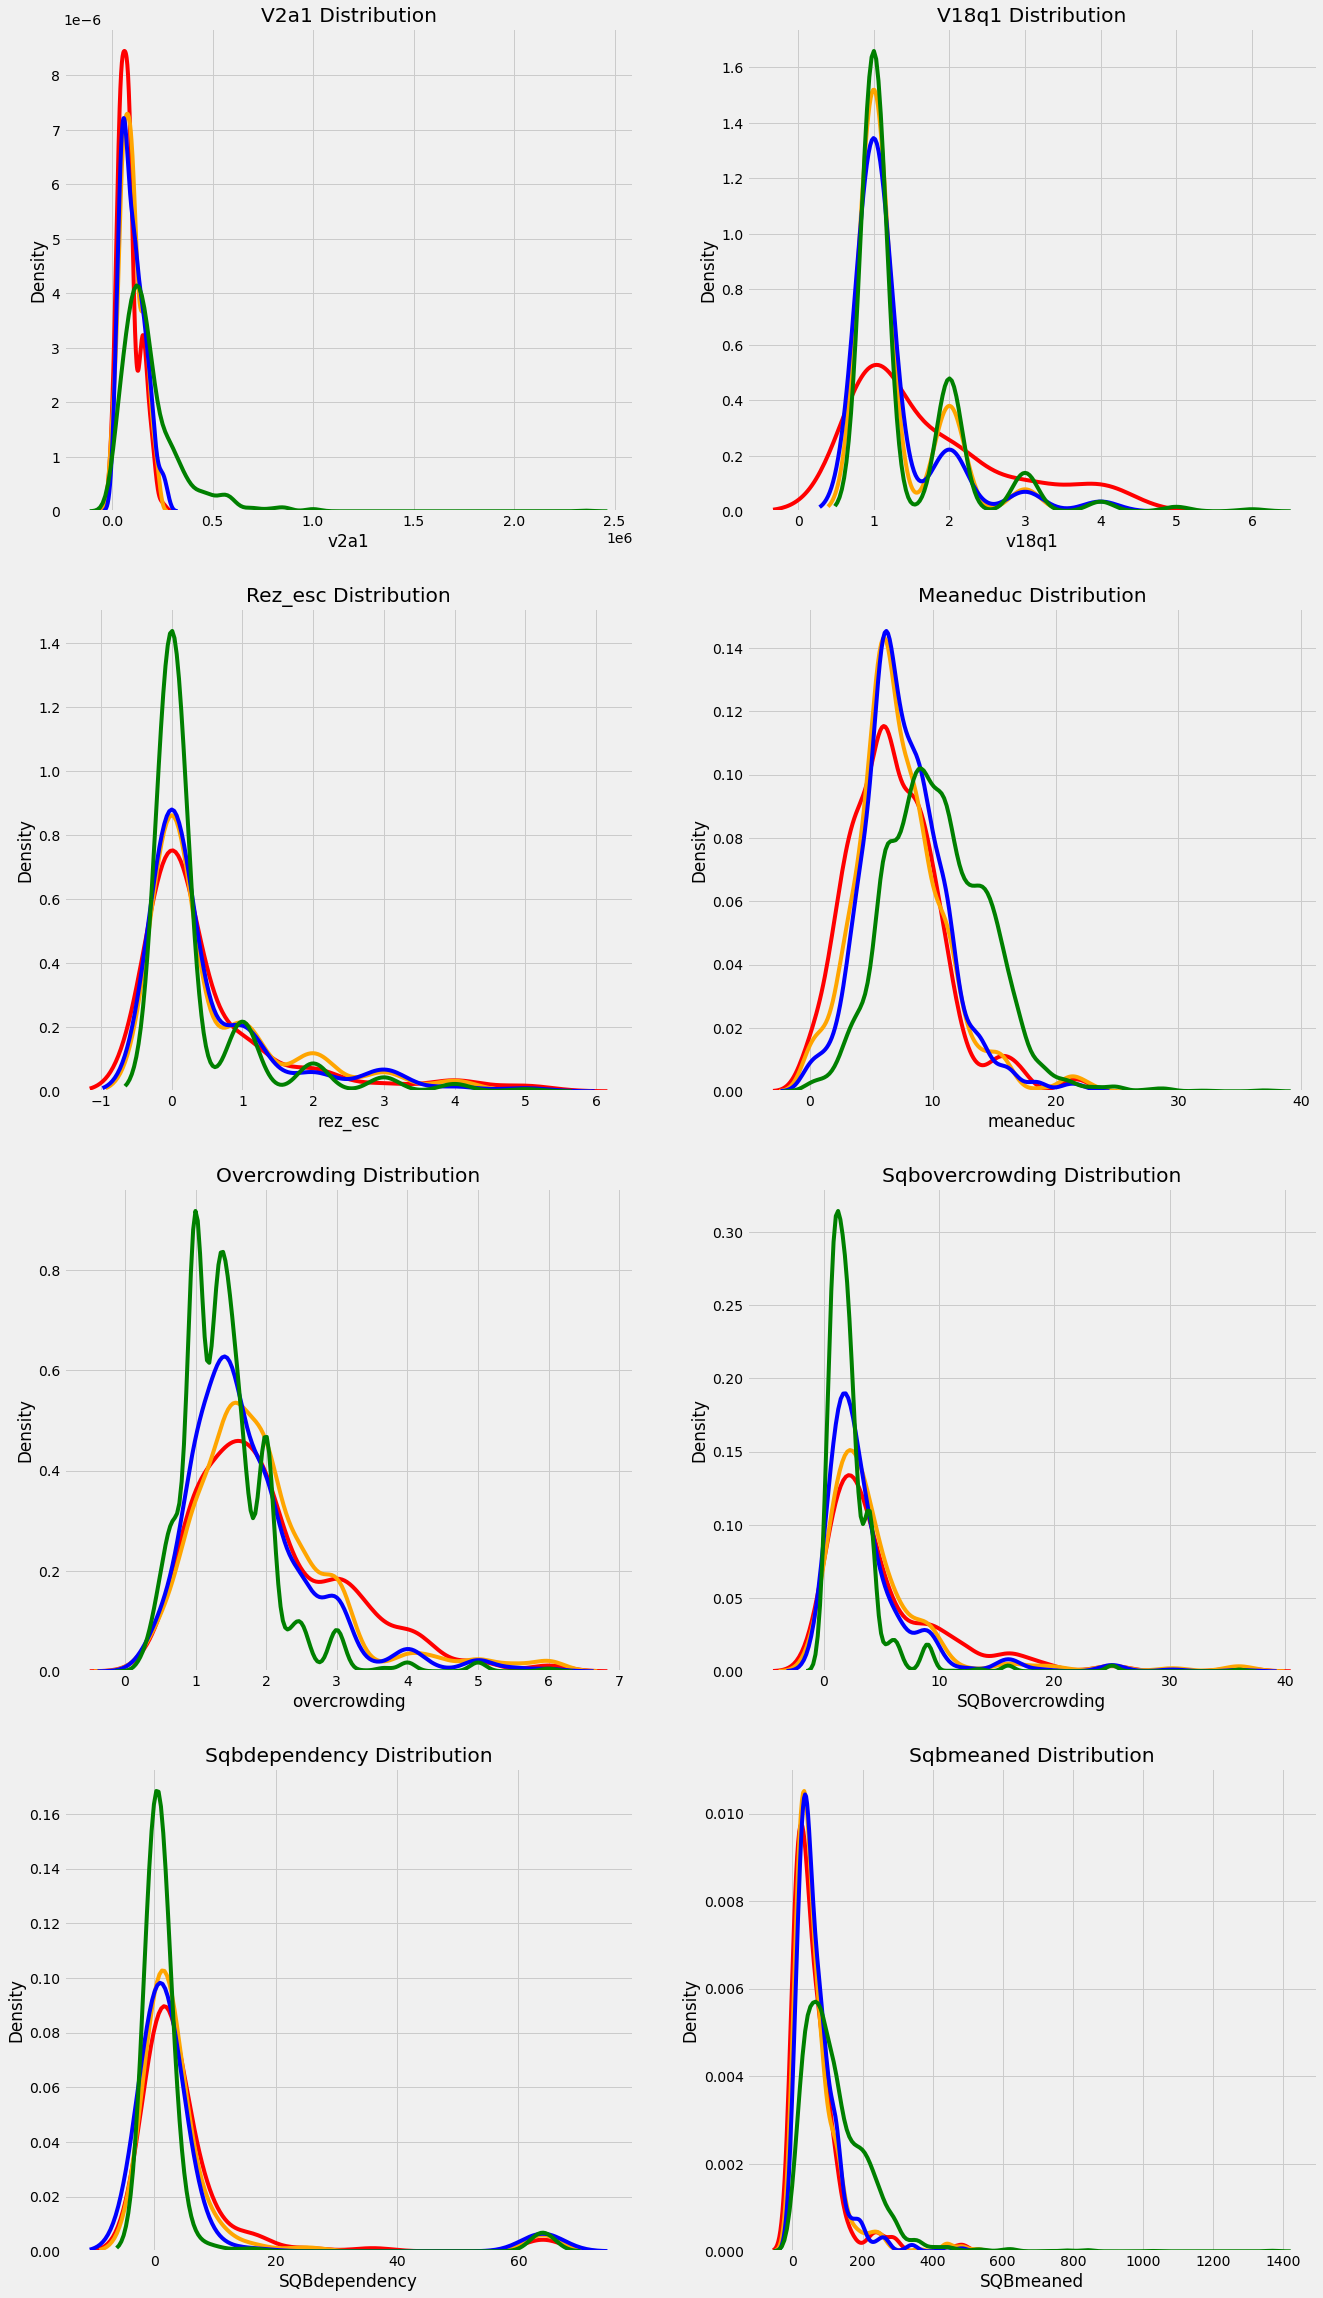

In [6]:
from collections import OrderedDict

plt.figure(figsize=(20, 16))
plt.style.use('fivethirtyeight')

# color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4:'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'nonvulnerable'})

# iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i+1)
    # iterate through the poverty levels
    for poverty_level, color in colors.items():
        # plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), ax=ax, color=color, label=poverty_mapping[poverty_level])
    
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')

plt.subplots_adjust(top=2)

Later on we'll calculate correlations between the variables and the Target to gauge the relationships between the features, but these plots can already give us a sense of which variables may be most 'relevant' to a model. For example, the meanduc, representing the average education of the adults in the household appears to be related to the poverty level: **a higher average adult education leads to higher values of the target which are less severe levels of poverty.** The theme of the importance of education is one we will come back to again and again in this notebook.

### Object Columns

The last column type is object which we can view as follow.

In [7]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


The id and idhogar object types make sense because these are identifying variables. However, the other columns seem to be a mix of strings and numvers which we'll need to address before doing any machine learning. According to the documentation for these columns:  
- dependency: Dependency rate, calculated = (number of  members of the household younger than 19 or older than 64)/(number of members of household between 19 and 64)
- edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes = 1 and no = 0
- edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes = 1 and no = 0  
  
These explanations clear up the issue. For these three variables, **'yes' = 1 and 'no' = 0**. We can correct the variables using a mapping and convert to floats.

In [8]:
mapping = {'yes': 1, 'no': 0}

# apply same operation to both train and test
for df in [train, test]:
    # fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


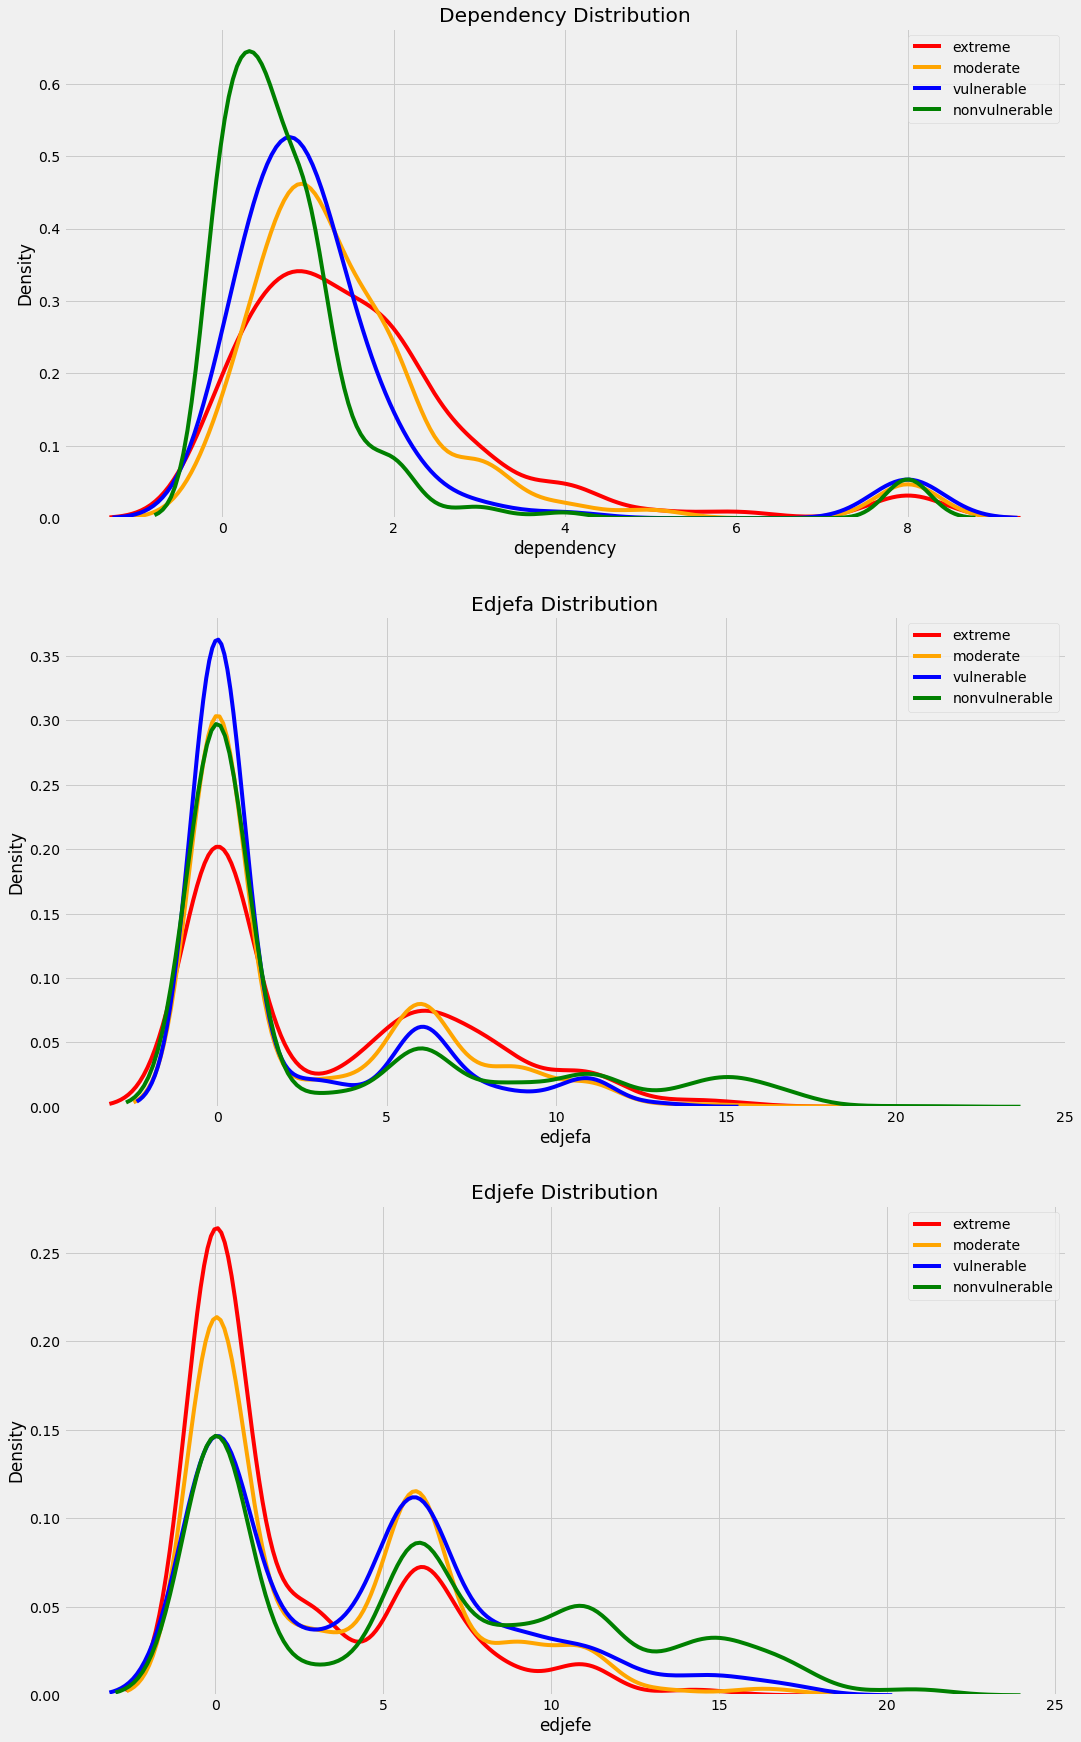

In [10]:
plt.figure(figsize=(16, 12))

# iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i+1)
    # iterate through the poverty levels
    for poverty_level, color in colors.items():
        # plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), ax=ax, color=color, label=poverty_mapping[poverty_level])
    
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    plt.legend()

plt.subplots_adjust(top=2)

These variables are now correctly represented as numbers and can be fed into a machine learning model.  
  
To make operations like that above a little easier, we'll join together the training and testing dataframe. This is important once we start feature engineering because we want to apply the same operations to both dataframes so we end up with the same features. Later we can separate our the sets based on the Target.

In [11]:
# add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index=True)

## Exploring Label Distribution

Next, we can get an idea of how imbalanced the problem is by looking at the distribution of labels. There are four possible integer levels, indicating four different levels of poverty. To look at the correct labels, we'll subset only to the columns where parentcsco1 == 1 because this is the head of household, the correct label for each household.  
  
The bar plot below shows the distribution of training labels (since there are no testing labels).

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

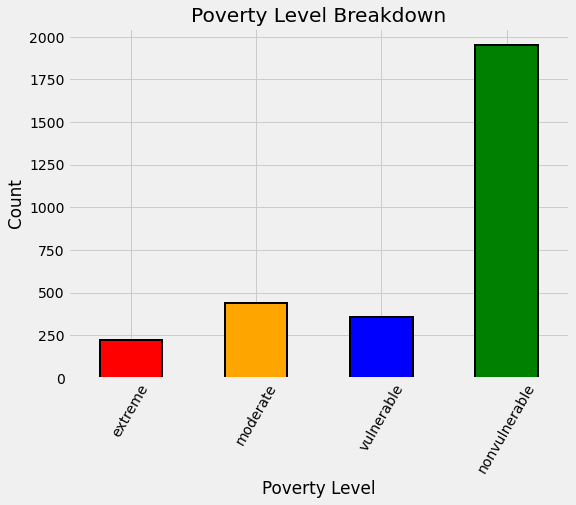

In [12]:
# heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# bar plot of occurrences of each label
label_counts.plot.bar(figsize=(8, 6), color=colors.values(), edgecolor='k', linewidth=2)

# formatting
plt.xlabel('Poverty Level')
plt.ylabel('Count')
plt.xticks([x-1 for x in poverty_mapping.keys()], list(poverty_mapping.values()), rotation=60)
plt.title('Poverty Level Breakdown')

label_counts

We are dealing with an imbalanced class problem (which makes it intriguing why the contest organizers choose the macro F1 score as the metric instead of weighted F1). There are many more households that classifiy as non vulnerable than in any other category. The extreme poverty class is the smallest (I guess this should make us optimistic).  
  
One problem with imbalanced classification problem is that the machine learning model can have a difficult time predicting the minority classes because it sees far less examples. Think about this in human terms: if we are classifying poverty and we see far more cases of no poverty than extreme poverty, it will make it more difficult for us to identify the high poverty households because of less exposure. One potential method to address class imbalanceds is through oversampling (which is covered in more advanced notebooks).

## Addressing Wrong Labels

As with any realistic dataset, the Costa Rican Poverty data has some issues. Typically, 80% of a data science project will be spent cleaning data and fixing anomalies/errors. These can be either human entry errors, measurement errors, or sometimes just extreme calues that are correct but stand out. For this problem, some of the labels are not correct because individuals in the same household have a different poverty level. We're not told why this may be the case, but we are told to use the head of household as the true label.  
  
That information makes our job much easier, but in a real-world problem, we would have to figure out the reason why the labels are wrong and how to address the issue on our own. This section fixes the issue with the labels although it is not strictly necessary: I kept it in the notebook just to show how we may deal with this issue.

### Identify Errors

First we need to find the errors before we can correct them. To find the hosueholds with different labels for family members, we can group the data by the household and then check if there is only one unique value of the Target.

In [13]:
# groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


In [14]:
# one example
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


The organizers tell us that the correct label is that for the head of household, where parentesco1 == 1. For this household, the correct label is 3 for all members. We can correct this (as shown later) by reassigning all the individuals in the household the correct poverty level. In the real-world, you mihgt have to make the tough decision of how to address the problem by yourself (or with the help of your team).

### Families without Heads of Household

We can correct all the label discrepancies by assigning the individuals in the same household the label of the head of household. But wait, you mak ask: "What if there are households without a head of household? And what if the members of those households have differing values of the label?"  
  
Well, since you asked, let's investigate exactly that quesetion.

In [15]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# find households without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [16]:
# find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

0 Households with no head have different labels.


For this problem, according to the organizers, **if a household does not have a head, then there is no true label. Therefore, we actually won't use any of the households without a head for training.** Nonetheless, it's still a good exercise to go through this process of investigating the data.

### Correct Errors

Now we can correct labels for the households that do have a head and the members have different poverty levels.

In [17]:
# iterate through each household
for household in not_equal.index:
    # find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])

    # set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target

# groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# households where targets are not all equal
not_equal = all_equal[all_equal != True]

print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


Sine we are only going to use the heads of household for the labels, **this step is not completely necessary but it shows a workflow for correcting data errors like you may encounter in real life.** Don't consider it extra work, just practice for your career.

## Missing Variables

One of the most important steps of exploratory data analysis is finding missing values in the data and determining how to handle them. Missing values have to be filled in before we use a machine learning model and we need to think of the best strategy for filling them in based on the feature: this is where we'll have to start digging into the data definitions.  
  
First we can look at the percentage of missing values in each column.

In [18]:
# number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns={0: 'total'})

# create a percentage missing
missing['percent'] = missing['total']/len(data)

missing.sort_values('percent', ascending=False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


We do need to address the 3 columns with a high percentage of missing values.  
  
**v18q1**: Number of tablets  
  
Let's start with v18q1 which indicates the number of tablets owned by a family. We can look at the value counts of this variables. Since this is a household variables, it only makes sense to look at it on a household level, so we'll only select the rows for the head of household.  

### Function to Plot Value Counts

Since we might want to plot value counts for different columns, we can write a simple function that will do it for us.

In [19]:
def plot_value_counts(df, col, head_only=False):
    '''Plot value counts of a column, optionally with only the heads of a household'''
    # select heads of household
    if head_only:
        df = df.loc[df['parentesco1'] == 1].copy()
    
    plt.figure(figsize=(8, 6))
    df[col].value_counts().sort_index().plot.bar(color='blue', edgecolor='k', linewidth=2)
    plt.xlabel(f'{col}')
    plt.title(f'{col} Value Counts')
    plt.ylabel('Count')
    plt.show()

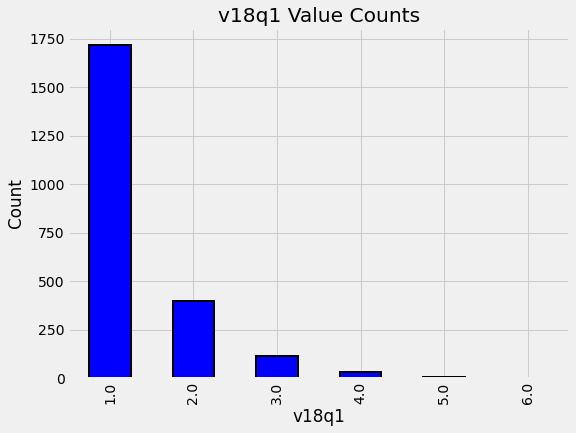

In [20]:
plot_value_counts(heads, 'v18q1')

It looks like the most common number of tablets to own is 1 if we go only by the data that is present. However, we also need to think about the data is missing. In this case, it could be that families with a nan in this category just do not own a tablet. If we look at the data definitions, we see that v18q indicates whether or not a family owns a tablet. We should investigate this column combined with the number of tablets to see if our hypothesis holds.  
  
We can gropuby the value of v18q (which is 1 for owns a tablet and 0 for does not) and then calculate the number of null values for v18q1. This will tell us if the null values represent that the family does not own a tablet.

In [21]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

Every family that has nan for v18q1 does not own a tablet. Therefore, we can fill in this missing value with zero.  
??? v18q1의 null은 25468개, v18q가 0이면서 null인 데이터는 8044. 전체 데이터보다 많다.

In [22]:
data['v18q1'] = data['v18q1'].fillna(0)

**v2a1**: Monthly rent payment  
  
The next missing column is v2a1 which represents the monthly rent payment.  
  
In addition to looking at the missing values of the monthly rent payment, it will be interesting to also look at the distribution of tipovivi_, the column showing the ownership/renting status of the home. For this plot, we show the ownership status of those homes with a nan for the monthly rent payment.

Text(0.5, 1.0, 'Home Ownership Status for Households Missing Rent Payments')

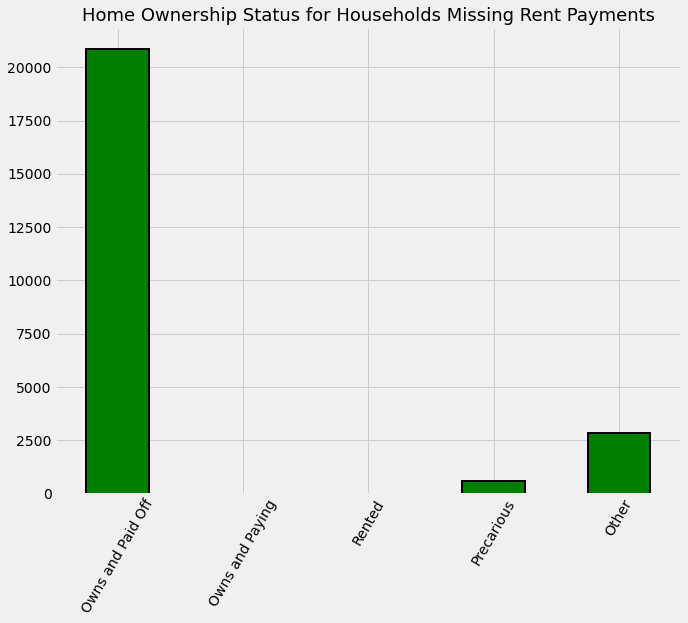

In [23]:
# variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]

# plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize=(10, 8), color='green', edgecolor='k', linewidth=2)
plt.xticks([0, 1, 2, 3, 4], ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'], rotation=60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size=18)

The meaning for the home ownership variables is below:  
  
```
tipovivi1, =1 own and fully paid house
tipovivi2, =1 own, paying in installments
tipovivi3, =1 rented
tipovivi4, =1 precarious
tipovivi5, =1 other(assigned, borrowed)
```  
  
mostly: the households that do not have a monthly rent payment generally own their own home. In a few other situations, we are not sure of the reason for the missing information.  
  
For the houses that are owned and have a missing monthly rent payment, we can set the value of the rent payment to zero. For the other homes, we can leave the missing values to be imputed but we'll add a flag (Boolean) column indicating that these households had missing values.

In [24]:
# fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

**rez_esc**: years behind in school  
  
The last column with a high percentage of missing value is rez_esc indicating years behind in school. For the families with a null value, is possible that they have no children currently in school. Let's test this out by finding the ages of those who have a missing value in this column and the ages of those who do not have a missing value.

In [25]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

What this tell us is that the oldest age with a missing value is 17. For anyone older than this, maybe we can assume that they are simply not in school. Let's look at the ages of those who have a missing value.

In [26]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

If we read through some of the discussion for this competition, we learn that this variable is only defined for individuals between 7 and 19. Anyone younger or older than this range presumably has no years behind and therefore the value shoul be set to 0. For this variable, if the individual is over 19 and they have a missing value, or if they are younger than 7 and have a missing value we can set it to zero. For anyone else, we'll leave the value to be imputed and add a boolean flag.

In [27]:
# if individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

There is also one outlier in the rez_esc column. Again, if we read through the competition discussion, we learn that the maximum value for this variable is 5. Therefore, any values above 5 should be set to 5.  
(kaggle discussion에 host가 답변남긴 것이 있다.)

In [28]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

## Plot Two Categorical Variables

To show how two categorical variables interact with one another, there are a number of plotting options: scatterplots, faceted bar plots, boxplots, etc. I wasn't satisfied with any of these choices so I wrote the function below, which essentially is a scatterplot of two categoricals where the size of the points represent the percentage of a given y-value represented by each x-value.

In [29]:
def plot_categoricals(x, y, data, annotate=True):
    '''Plot counts of two categoricals. Size is raw count for each grouping. Percentages are for a given value of y.'''
    
    # raw counts
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize=False))
    raw_counts = raw_counts.rename(columns={x: 'raw_count'})

    # calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize=True))

    # rename the column and reset the index
    counts = counts.rename(columns={x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']

    # add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])

    plt.figure(figsize=(14, 10))
    
    # scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolors='k', color='lightgreen', s=100*np.sqrt(counts['raw_count']), marker='o', alpha=0.6, linewidths=1.5)

    if annotate:
        # annotate the plot with text
        for i, row in counts.iterrows():
            # put text with appropriate offsets
            plt.annotate(
                xy=(row[x] - (1 / counts[x].nunique()), row[y] - (0.15 / counts[y].nunique())),
                color='navy', s=f"{round(row['percent'], 1)}%"
                )
    
    # set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())

    # transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))

    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max, int((sqr_max - sqr_min) /5)))
    markers = []

    # markers for legend
    for size in msizes:
        markers.append(
            plt.scatter([], [], s=100*size, label=f'{int(round(np.square(size)/100)*100)}', 
            color='lightgreen', alpha=0.6, edgecolors='k', linewidths=1.5))
    
    # legend and formatting
    plt.legend(handles=markers, title='Counts', labelspacing=3, handletextpad=0.2, fontsize=16, loc=[1.10, 0.19])

    plt.annotate(f'* Size represents raw count while % is for a given y value.', xy=(0, 1), xycoords='figure points', size=10)

    # adjust axes limits
    plt.xlim((
        counts[x].min() - (6 / counts[x].nunique()),
        counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((
        counts[y].min() - (4 / counts[y].nunique()),
        counts[y].max() + (4 / counts[y].nunique())
    ))
    plt.grid(None)
    plt.xlabel(f'{x}')
    plt.ylabel(f'{y}')
    plt.title(f'{y} vs {x}')

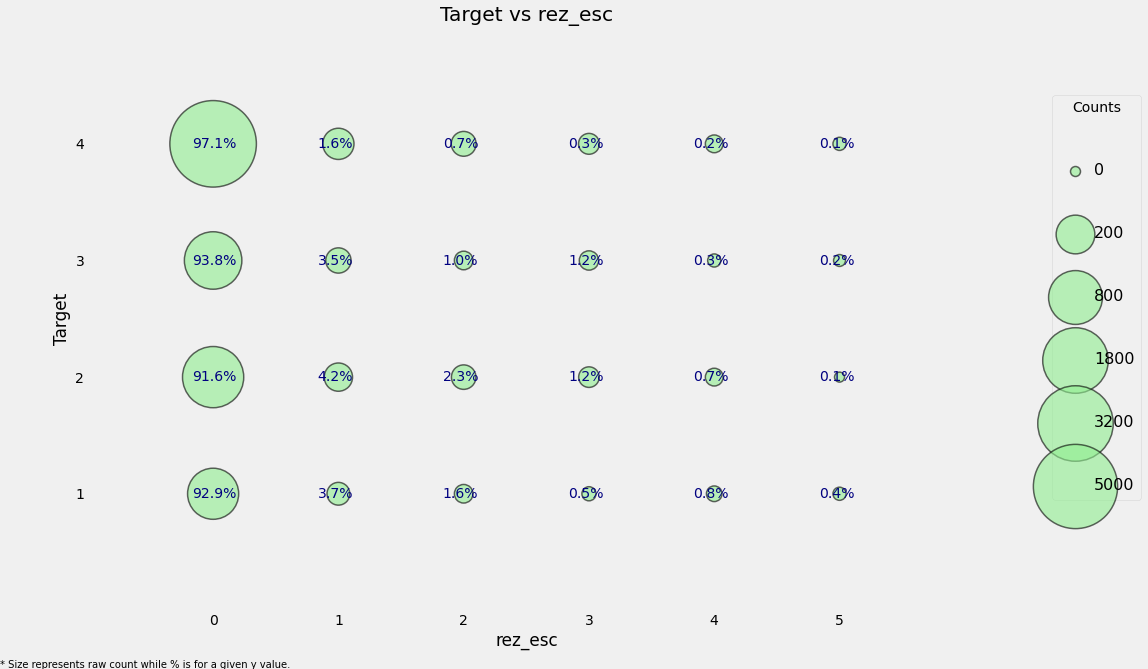

In [30]:
plot_categoricals('rez_esc', 'Target', data)

The size of the markers represents the raw count. To read the plot, choose a given y-value and then read across the row. For example, with a poverty level of 1, 93% of individuals have no years behind with a total count of around 800 individuals and about 0.4% of individuals have no years are 5 years behind with about 50 total individuals in this category. This plot attempts to show both the overall counts and the within category proportion; it's not perfect, but I gave a shot.

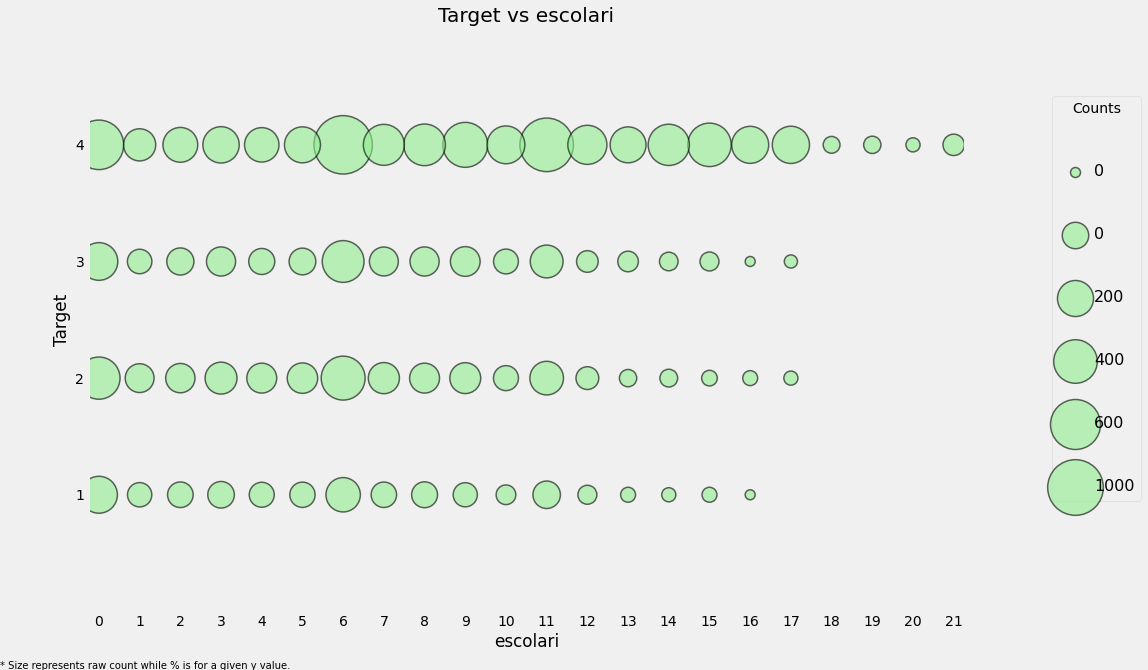

In [31]:
plot_categoricals('escolari', 'Target', data, annotate=False)

The ramaining maissing values in each column will be filled in, a process known as Imputation. There are several types of imputation commonly used, and one of the simplest and most effective methods is to fill in the missing values with the median of the column.  
  
As a final step with the missing values, we can plot the distribution of target for the case where either of these values are missing.

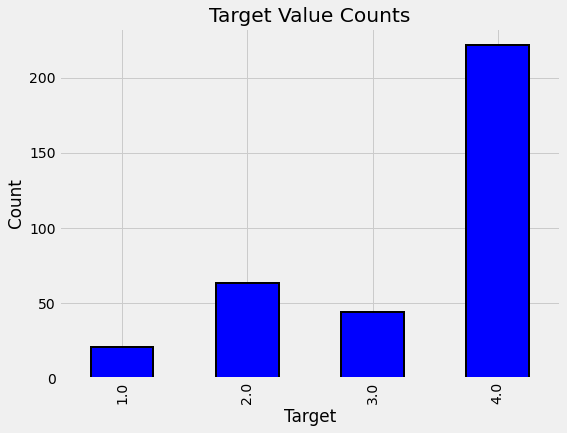

In [32]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 'Target')

This distribution here seems to match that for all the data at large.

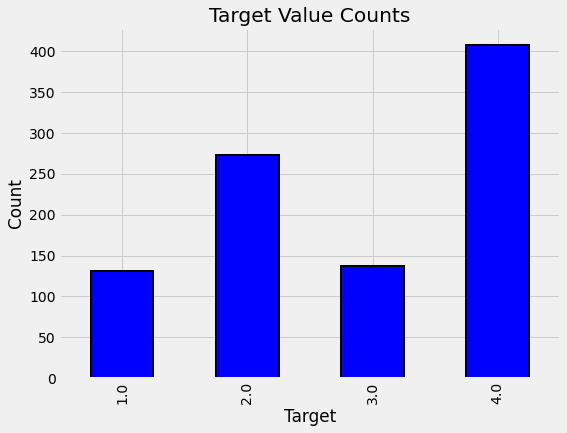

In [33]:
plot_value_counts(data[(data['v2a1-missing'] == 1)], 'Target')

This looks like it could be an indicator of more poverty given the higher prevalence of 2: moderate poverty.  
  
**This represents an important point**: sometimes the missing information is just as important as the information you are given.

# Feature Engineering

There is plenty more exploratory data analysis we can do, but first we should work on consolidating our data at a household level. We already have some of the information for each household, but for training, we will need all of the information summarized for each household. This means grouping the individuals in a house (groupby) and performing an aggregation (agg) of the individual variables.  
  
In another notebook, I show how we can use automated feature engineering to do this, and **automated feature engineering** should be a standard part of the machine learning workflow. Right now, we'll stick to doing this by hand, but definitely take a look at **automated feature engineering in Featuretools.**

## Column Definitions

Sometimes in data science we have to get our hands dirty digging through the data or do tedious tasks that take a lot of time. This is that part of the analysis: we have to define the columns that are at an individual level and at a household level using the data descriptions. There is simply no ohter way to identify which variables at are the household level than to go through the variables themselves in the data description. Except, I've already done this for you, so all you have to do is copy and paste.  
  
We'll define different variables because we need to treat some of them in a different manner. Once we have the variables difined on each level, we can work to start aggregating them as needed.  
  
The process is as follows  
1. Break variables into household level and individual level
2. Find suitalbe aggregations for the individual level data
- Ordinal variables can use statistical aggregations
- Boolean variables can also be aggregated but with fewer stats
3. Join the individual aggregation to the household level data

### Define Variable Categories

There are several different categories of variables:
1. Individual Variables: these are characteristics of each individual rather than the household
- Boolean: Yes or No (0 or 1)
- Ordered Discrete: Integers with an ordering
2. Household Variables
- Boolean: Yes or No
- Ordered Discrete: Integers with an ordering
- Continuous numeric
3. Squared Variables: derived from squaring variables in the data
5. Id Variables: identifies the data and should not be used as features  
  
Below we manually define the variables in each category. This is a little tedious, but also necessary.

In [34]:
id_ = ['Id', 'idhogar', 'Target']

In [35]:
ind_bool = [
    'v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7',
    'parentesco1', 'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 
    'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12',
    'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5',
    'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9', 'mobilephone', 'rez_esc-missing'
]

ind_ordered = ['rez_esc', 'escolari', 'age']

In [36]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 'abastaguadentro', 'abastaguafuera', 'abastaguano',
           'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [
    'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
    'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [37]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

Let's make sure we covered all of the variables and didn't repeat any.

In [38]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

from collections import Counter

print('There are no repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('We covered every variable: ', len(x) == data.shape[1])

There are no repeats:  True
We covered every variable:  True


**Squared Variables**  
  
First, the easiest step: we'll remove all of the squared variables. Sometimes variables are squared or transformed as part of feature engineering because it can help linear models learn relationships that are non-linear. However, since we will be useing more complex models, these squared features are redundant. They are highly correlated with the non-squared version, and hence can actually hurt our model by adding irrelevant information and also slowing down training.  
  
For example, let's take a look at SQBage vs age.

Text(0.5, 1.0, 'Squared Age versus Age')

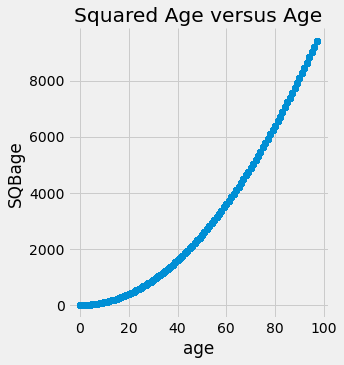

In [39]:
sns.lmplot('age', 'SQBage', data=data, fit_reg=False)
plt.title('Squared Age versus Age')

This variables are highly correlated, and we don't need to keep both in our data.

In [40]:
# remove squared variables
data = data.drop(columns=sqr_)
data.shape

(33413, 136)

## Id Variables

These are pretty simple: they will be kept as is in the data since we need them for identification.

## Household Level Variables

First let's subset to the heads of household and then to the household level variables.

In [41]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

For most of the household level variables, we can simply keep them as is: since we want to make predictions for each household, we use these variables as features. However, we can also remove some redundant variables and also add in some more features derived from existing data.

### Redundant Household Variables

Let's take a look at the correlations between all of the household variables. If there are any that are too highly correlated, then we might want to remove one of the pair of highly correlated variables.  
  
The following code identifies any variables with a greater than 0.95 absolute magnitude correlation.

In [42]:
# create correlation matrix
corr_matrix = heads.corr()

# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) # ??? triu

# find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

These show one out of each pair of correlated variables. To find the other pari, we can subset the corr_matrix.

In [43]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


<AxesSubplot:>

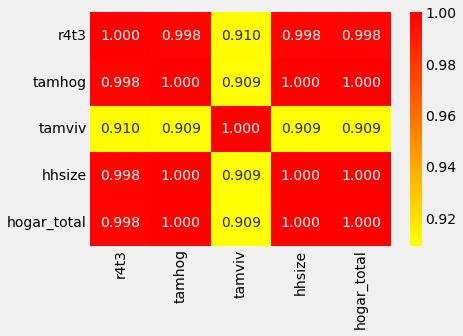

In [44]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9], annot=True, cmap=plt.cm.autumn_r, fmt='.3f')

There are several variables here having to do with the size of the house:
- r4t3, total persons in the household
- tamhog, size of the household
- tamviv, number of persons living in the household
- hhsize, household size
- hogar_total, # of total individuals in the household  
  
These variables are all highly correlated with one another. In fact, hhsize has a perfect correlation with tamhog and hogar_total. We will remove these two variables because the information is redundant. We can also remove r4t3 because it has a near perfect correlation with hhsize.  
  
tamviv is not necessarily the same as hhsize because there might be family members that are not living in the household. Let's visualize the difference in a scatterplot.

In [45]:
heads = heads.drop(columns=['tamhog', 'hogar_total', 'r4t3'])

Text(0.5, 1.0, 'Household size vs number of persons living in the household')

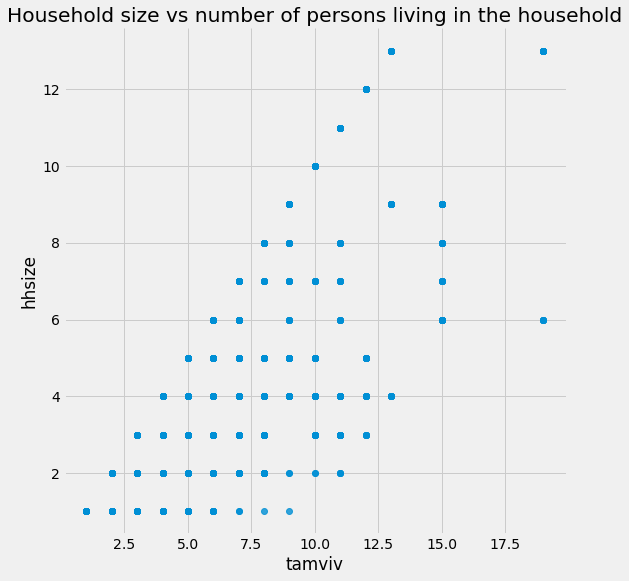

In [46]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size=8)
plt.title('Household size vs number of persons living in the household')

We see for a number of cases, there are more people living in the household than there are in the family. This gives us a good idea for a new feature: **the defferent between these two measurements**  
  
Let's make this new feature.

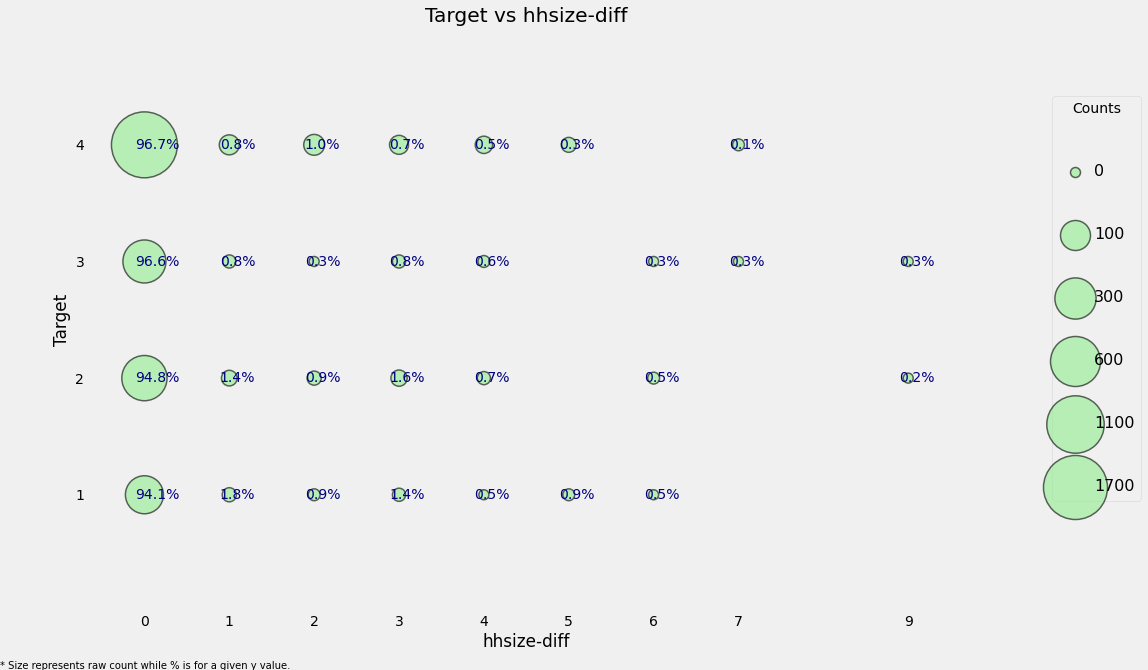

In [47]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff', 'Target', heads)

Even though most households do not have a difference, there are a few that have more people living in the household than are members of the household.  
  
Let's move on to the other redundant variables. First we can look at coopele.

In [48]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


These variables indicate where the electricity in the home is coming from. There are four options, and the families that don't have one of these two options either have no electricity (noelec) or get it from a private plant (planpri).

**Creating Ordinal Variable**  
  
I'm going to compress these four variables into one by creating an ordinal variable. I'm going to choose the mapping myself, based on the data decriptions:  
```
0: No electricity
1: Electricity from cooperative
2: Electricity from CNFL, ICA, ESPH/JASEC
3: Electrictiy from private plant
```
  
An ordered variable has an inherent ordering, and for this we choose our own based on the domain knowledge. After we create this new ordered variable, we can drop the four others. There are several households that do not have a variable here, so we will use a nan (which will be filled in during imputation) and add a Boolean column indicating there was no measure for this variable.

In [49]:
elec = []

# assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)

# record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

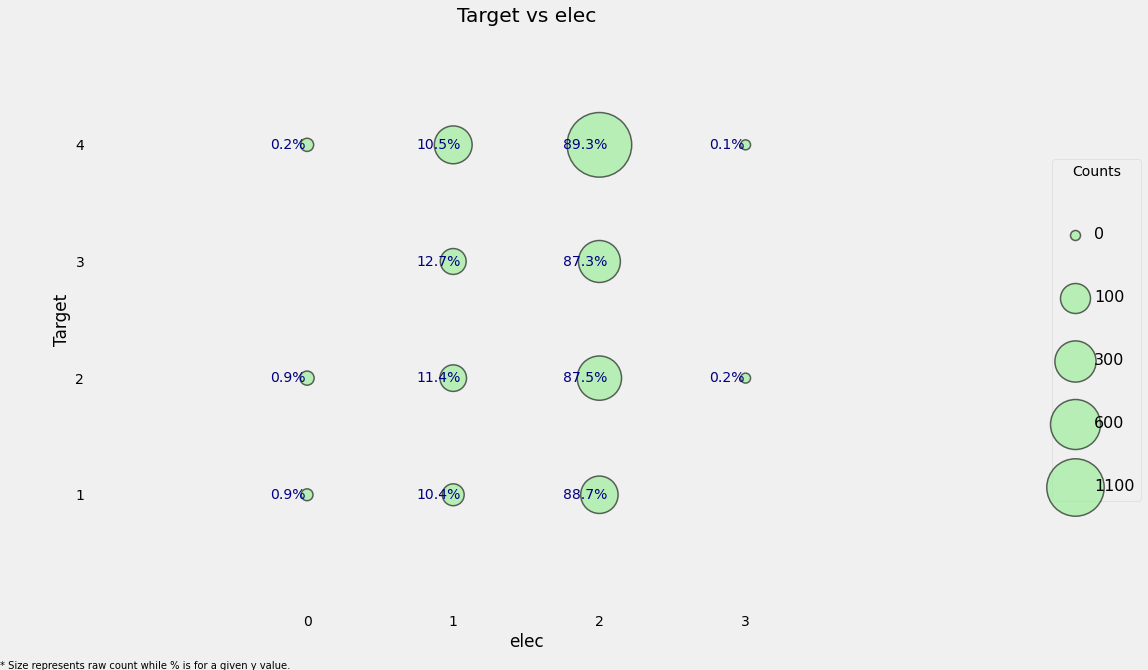

In [50]:
plot_categoricals('elec', 'Target', heads)

We can see that for every value of the Target, the most common source of electricity is from one of the listed providers.
  
The final redundant column is area2. This means the house is in a rural zone, but it's redundant because we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.

In [51]:
heads = heads.drop(columns='area2')

heads.groupby('area1')['Target'].value_counts(normalize=True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

It seems like households in an urban area (value of 1) are more likely to have lower poverty levels than households in a rural area (value of 0)

### Creating Ordinal Variables

For the walls, roof, and floor of the house, there are three columns each: the first indicating 'bad', the second 'regular', and the third 'good'. We could leave the variables as booleans, but to me it makes more sense to turn them into ordinal variables because there is an inherent order: bad < regular < good. To do this, we can simply find whichever column is non-zero for each household using np.argmax.  
  
Once we have created the ordinal variable, we are able to drop the original variables.

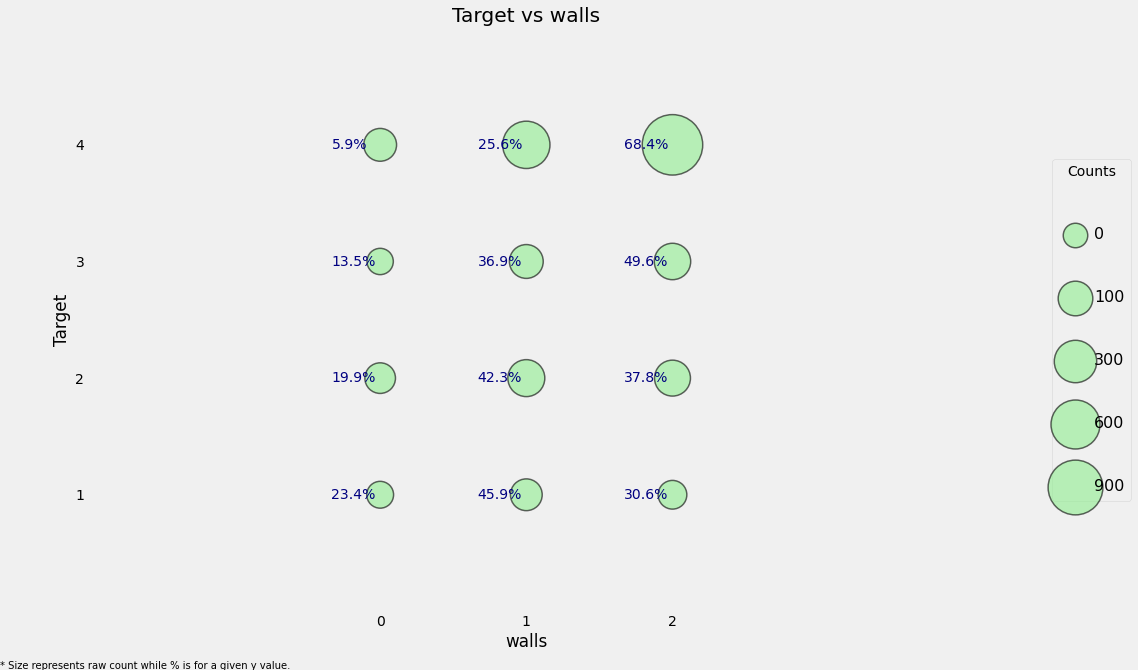

In [52]:
# wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]), axis=1)

plot_categoricals('walls', 'Target', heads)

In [54]:
# roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]), axis=1)
heads = heads.drop(columns=['etecho1', 'etecho2', 'etecho3'])

# floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]), axis=1)

## Feature Construction

In addition to mapping variables to ordinal features, we can also create entirely new features from the existing data, known as feature construction. For example, we can add up the previous three features we just created to get an overall measure of the quality of the house's structure.

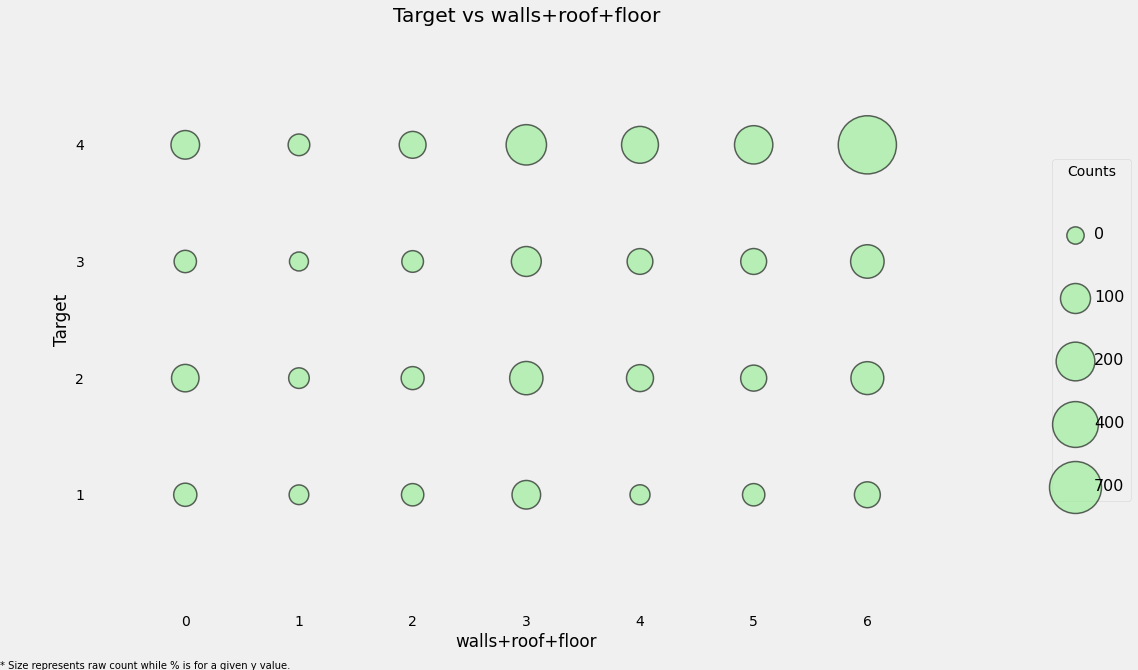

In [55]:
# create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

plot_categoricals('walls+roof+floor', 'Target', heads, annotate=False)

This new feature may be useful because it seems like a Target of 4 (the lowest poverty level) tends to have higher values of the 'house quality' variable. We can also look at this in a table to get the fine-grained details.

In [56]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize=True)).rename(columns={'Target':'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


The next variable will be a warning about the quality of the house. It will be a negative value, with -1 point each for no toilet, electricity, floor, water service, and ceiling.

In [57]:
# no toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (
    heads['sanitario1'] + (heads['elec'] == 0) + heads['pisonotiene'] + heads['abastaguano'] + (heads['cielorazo'] == 0)
)

We can keep using our plot_categoricals function to visualize these relationships, but seaborn also has a number of plotting options that can work with categoricals. One is the violinplot which shows the distribution of variable on the y axis with the width of each plot showing the number of observations in that category.

Text(0.5, 1.0, 'Target vs Warning Variables')

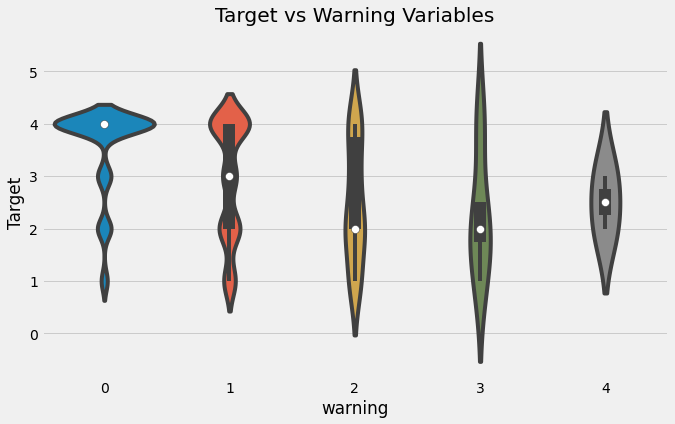

In [58]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='warning', y='Target', data=heads)
plt.title('Target vs Warning Variables')

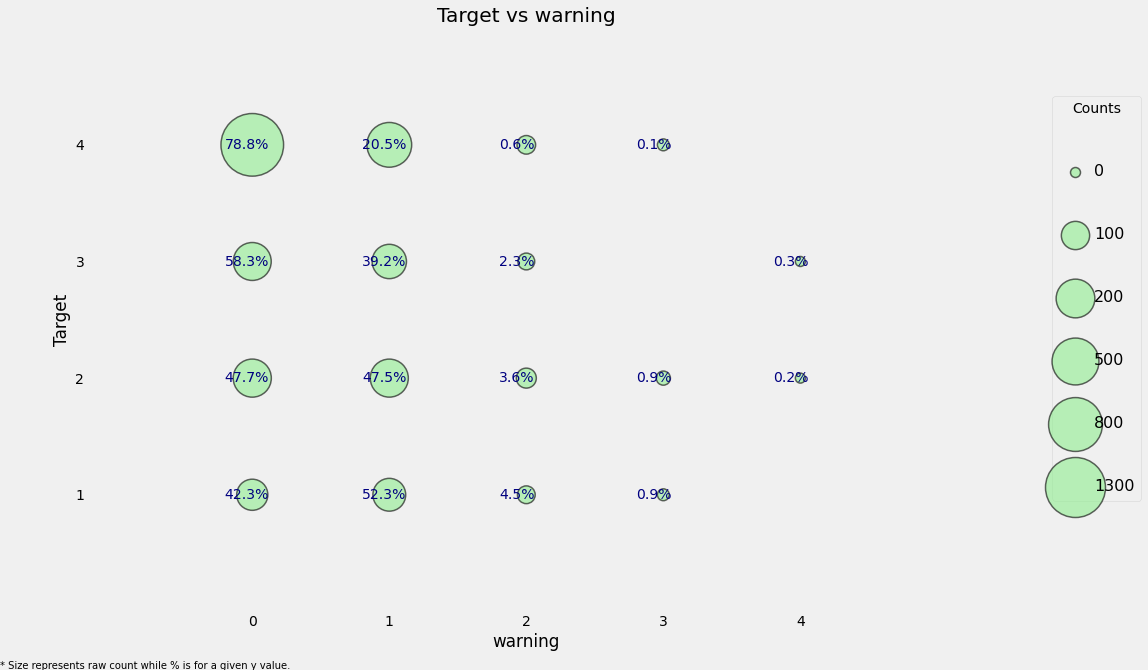

In [59]:
plot_categoricals('warning', 'Target', data=heads)

The violinplot is not great here because it smooths out the categorical variable with the effect that it looks as if the Target can take on lesser and greater values than in reality. Nonetheless, we can see a high concentration of households that have no warning signs and have the lowest level of poverty. It looks as if this may be a useful feature, but we can't know for sure until we get to modeling.  
  
The final household feature we can make for now is a bonus where a family gets a point for having a refrigerator, computer, tablet, or television.

Text(0.5, 1.0, 'Target vs Bonus Variable')

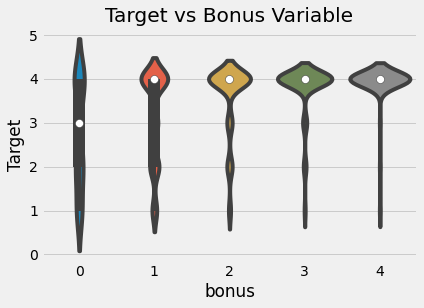

In [60]:
# owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (
    heads['refrig'] + heads['computer'] + (heads['v18q1'] > 0) + heads['television']
)

sns.violinplot('bonus', 'Target', data=heads, figsize=(10, 6))
plt.title('Target vs Bonus Variable')

## Per Capita Features

Additional features we can make calculate the number of certain measurements for each person in the household.

In [61]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita']  = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

## Exploring Household Variables

After going to all the trouble of getting our features in order, now we can take a look at them in relation to the Target. We've already done a little of this, but now we can try to quantify relationships.

### Measuring Relationships

There are many ways for measuring relationships between two variables. Here we will examine two of these:
1. The Pearson Correlation: from -1 to 1 measuring the linear relationship between two variables
2. The Spearman Correlation: from -1 to 1 measuring the monotonic relationship between two variables  
  
The Spearman correlation is 1 if as one variable increases, the other does as well, even if the relationship is not linear. On the other hand, the Pearson coreelation can only if the increase is exactly linear. These are best illustrated by example.

In [62]:
from scipy.stats import spearmanr

In [64]:
def plot_corrs(x, y):
    '''Plot data and show the spearman and pearson correlation.'''

    # calculate correlations
    spr = spearmanr(x, y).correlation
    pcr = np.corrcoef(x, y)[0, 1]

    # scatter plot
    data = pd.DataFrame({'x': x, 'y': y})
    plt.figure(figsize=(6, 4))
    sns.regplot('x', 'y', data=data, fit_reg=False)
    plt.title(f'Spearman: {round(spr, 2)}; Pearson: {round(pcr, 2)}')

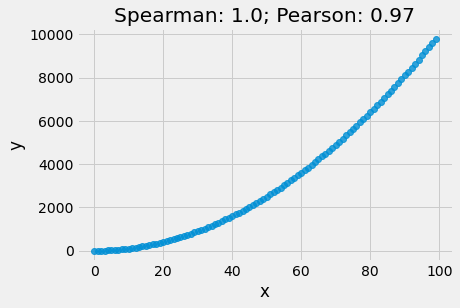

In [65]:
x = np.array(range(100))
y = x ** 2

plot_corrs(x, y)

The Spearman correlation is often considered to be better for ordinal variables such as the Target or the years of education. Most relationship in the real world aren't linear, and although the Pearson correlation can be an approximation of how related two variables are, it's inexact and not the best method of comparison.

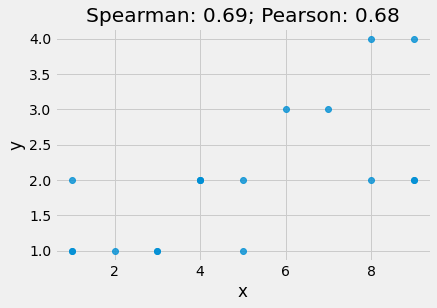

In [66]:
x = np.array([1, 1, 1, 2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9])
y = np.array([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 2, 4, 2, 2, 4])

plot_corrs(x, y)

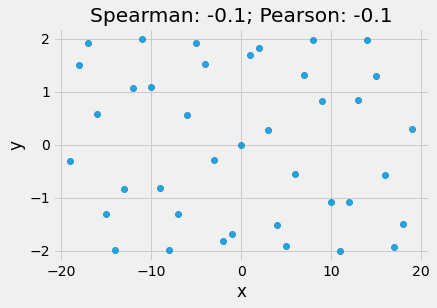

In [67]:
x = np.array(range(-19, 20))
y = 2 * np.sin(x)

plot_corrs(x, y)

First, we'll calculrate the Pearson correlation of every variable with the Target.

In [68]:
# use only training data
train_heads = heads.loc[heads['Target'].notnull(), :].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns={'Target':'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns={'index':'feature'})

print('Most negatively correlated variables:')
print(pcorrs.head())

print('\nMost positively correlated variables:')
print(pcorrs.dropna().tail())

Most negatively correlated variables:
        feature     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  overcrowding -0.234954
4         eviv1 -0.217908

Most positively correlated variables:
               feature     pcorr
97   phones-per-capita  0.299026
98               floor  0.307605
99    walls+roof+floor  0.332446
100           meaneduc  0.333652
101             Target  1.000000


For the negative correlations, as we increase the variable, the Target decreases indicating the poverty severity increases. Therefore, as the warning increases, the poverty level also increases which makes sense because this was meant to show potential bad signs about a house. The hogar_nin is the number of children 0-19 in the family which also makes sense: younger children can be financial source of stress on a family leading to higher levels of poverty. Or, families with lower socioeconomic status have more children in the hopes that one of them will be able to succeed.  
  
On the other hand, for the positive correlations, a higher value means a higher value of Target indicating the poverty severity decreases. The most highly correlated household level variable is meaneduc, the average education level of the adults in the household. This relationship between education and poverty intuitively makes sense: greater levels of education generally correlate with lower levels of poverty. We don't necessarily know which causes which, but we do know these tend to move in the same direction.  
  
Correlation values:
- .00-.19 'very week'
- .20-.39 'weak'
- .40-.59 'moderate'
- .60-.79 'strong'
- .80-1.0 'very strong'  
  
What these correlations show is that there are some weak relationships that hopefully our model will be able to use to learn a mapping from the features to the Target.  
  
Now we can move on to the Spearman correlation.

In [69]:
feats = []
scorr = []
pvalues = []

# iterate through each column
for c in heads:
    # only valid for numbers
    if heads[c].dtype != 'object':
        feats.append(c)
    
        # calculate spearman correlation
        scorr.append(spearmanr(train_heads[c], train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c], train_heads['Target']).pvalue)

scorrs = pd.DataFrame({'feature': feats, 'scorr': scorr, 'pvalue': pvalues}).sort_values('scorr')

The Spearman correlation coefficient calculation also comes with a pvalue indicating the significance level of the relationship. Any pvalue less than 0.05 is generally regarded as significant, although since we are doing multiple comparisons, we want to divide the p-value by the number of comparisons, a process known as the Bonferroni correction.

In [70]:
print('Most negative Spearman correlations:')
print(scorrs.head())
print('\nMost positive Spearman correlations:')
print(scorrs.dropna().tail())

Most negative Spearman correlations:
       feature     scorr        pvalue
97     warning -0.307326  4.682829e-66
68  dependency -0.281516  2.792620e-55
85   hogar_nin -0.236225  5.567218e-39
80        r4t1 -0.219226  1.112230e-33
49       eviv1 -0.217803  2.952571e-33

Most positive Spearman correlations:
              feature     scorr        pvalue
23          cielorazo  0.300996  2.611808e-63
95              floor  0.309638  4.466091e-67
99  phones-per-capita  0.337377  4.760104e-80
96   walls+roof+floor  0.338791  9.539346e-81
0              Target  1.000000  0.000000e+00


For the most part, the two methods of calculating correlations are in agreement. Just out of curiousity, we can look for the values that are furthest apart.

In [71]:
corrs = pcorrs.merge(scorrs, on = 'feature')
corrs['diff'] = corrs['pcorr'] - corrs['scorr']

corrs.sort_values('diff').head()

,feature,pcorr,scorr,pvalue,diff
77,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119
85,v18q1,0.197493,0.244200,1.282664e-41,-0.046708
87,tablets-per-capita,0.204638,0.248642,3.951568e-43,-0.044004
2,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691
97,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351


In [72]:
corrs.sort_values('diff').dropna().tail()

,feature,pcorr,scorr,pvalue,diff
57,techozinc,0.014357,0.003404,8.528369e-01,0.010954
49,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549
88,edjefe,0.235687,0.214736,2.367521e-32,0.020951
66,edjefa,0.052310,0.005114,7.804715e-01,0.047197
17,dependency,-0.126465,-0.281516,2.792620e-55,0.155051


The largest discrepancy in the correlations is dependency. We can make a scatterplot of the Target versus the dependency to visualize the relationship. We'll add a little jitter to the plot because these are both discrete variables.

Text(0.5, 1.0, 'Target vs Dependency')

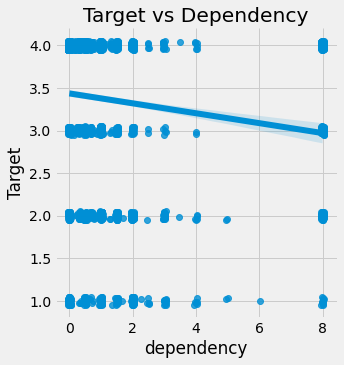

In [73]:
sns.lmplot('dependency', 'Target', fit_reg=True, data=train_heads, x_jitter=0.05, y_jitter=0.05)
plt.title('Target vs Dependency')

It's hard to see the relationship, but it's slightly negative: as the dependency increase, the value of the Target decreases. This makes sense: the dependency is the number of dependent individuals divided by the number of non-dependents. As we increase this value, the poverty severty tends to increase: having more dependent family members (who usually are non-working) leads to higher levels of poverty because they must be supported by the non-dependent family members.

Text(0.5, 1.0, 'Target vs Rooms Per Capita')

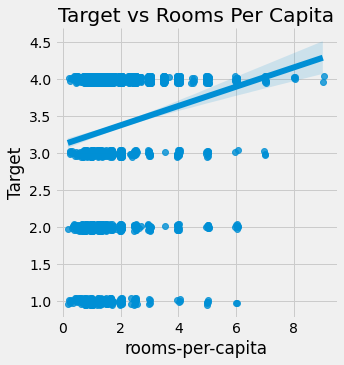

In [75]:
sns.lmplot('rooms-per-capita', 'Target', fit_reg=True, data=train_heads, x_jitter=0.05, y_jitter=0.05)
plt.title('Target vs Rooms Per Capita')

**Correlation Heatmap**  
  
One of my favorite plots is the correlation heatmap because it shows a ton of info in one image. For the heatmap, we'll pick 7 variables and show the correlations between themselves and with the target.

<AxesSubplot:>

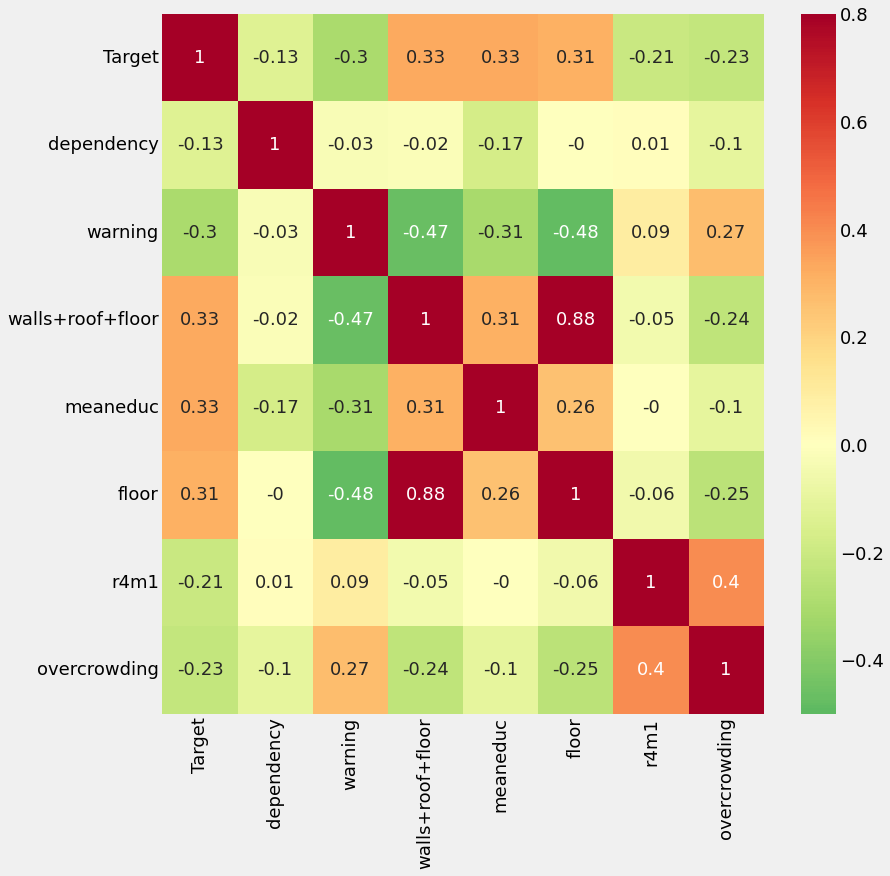

In [76]:
variables = ['Target', 'dependency', 'warning', 'walls+roof+floor', 'meaneduc', 'floor', 'r4m1', 'overcrowding']

# calculate the correlations
corr_mat = train_heads[variables].corr().round(2)

# draw a correlation heatmap
plt.rcParams['font.size'] = 18
plt.figure(figsize=(12, 12))
sns.heatmap(corr_mat, vmin=-0.5, vmax=0.8, center=0, cmap=plt.cm.RdYlGn_r, annot=True)

This plot shows us that there are a number of variables that have a week correlation with the Target. There are also high correlations between some variables (such as floor and walls+roof+floor) which could pose an issue because of collinearity.

### Features Plot

For the final exploration of the household level data, we can make a plot of some of the most correlated variables with the Target. This shows scatterplots on the upper triangle, kernel density estimate (kde) plots on the diagonal, and 2D KDE plots on the lower triangle.

Text(0.5, 1.05, 'Feature Plots Colored By Target')

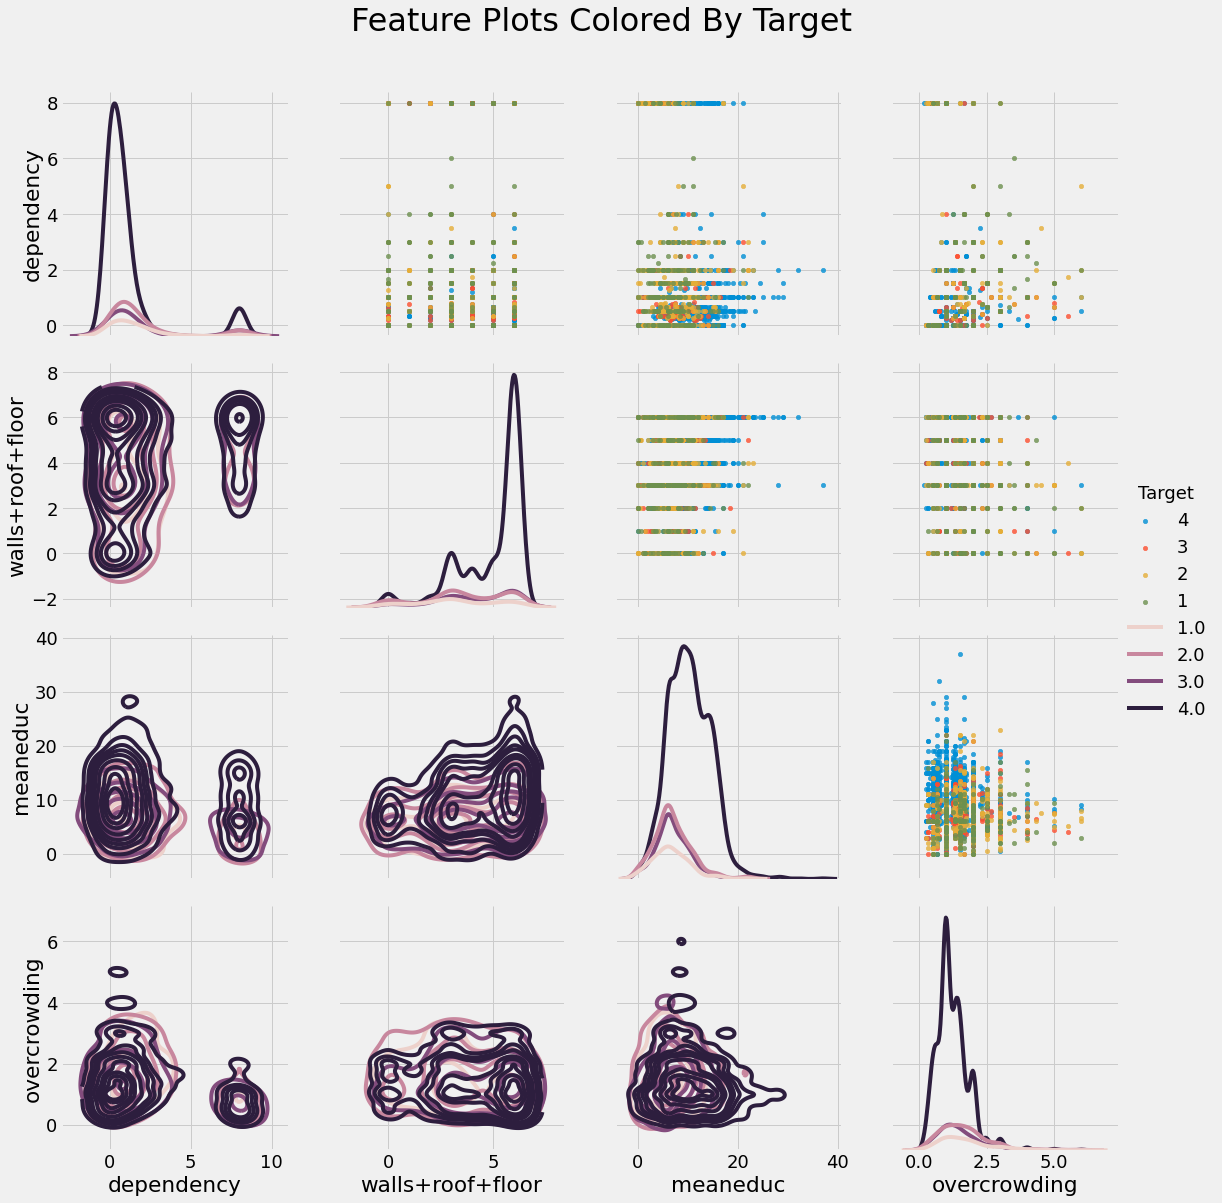

In [77]:
# copy the data for plotting
plot_data = train_heads[['Target', 'dependency', 'walls+roof+floor', 'meaneduc', 'overcrowding']]

# create the pairgrid object
grid = sns.PairGrid(
    data=plot_data, size=4, diag_sharey=False, hue='Target', hue_order=[4, 3, 2, 1],
    vars=[x for x in list(plot_data.columns) if x != 'Target']
    )

# upper is a scatter plot
grid.map_upper(plt.scatter, alpha=0.8, s=20)

# diagonal is a histogram
grid.map_diag(sns.kdeplot)

# bottom is density plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)
grid = grid.add_legend()
plt.suptitle('Feature Plots Colored By Target', size=32, y=1.05)

We'll leave the feature engineering of the household variables for now. Later, we can come back to this step if we are not pleased with the model performance.

In [78]:
household_feats = list(heads.columns)

## Individual Level Variables

There are two types of individual level variables: Boolean (1 or 0 for True or False) and ordinal (discrete values with a meaningful ordering).

In [79]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 40)

### Redundant Individual Variables

We can do the same process we did with the household level variables to identify any redundant individual variables. We'll focus on any variables that have an absolute magnitude of the correlation coefficient greater than 0.95.

In [82]:
# create correlation matrix
corr_matrix = ind.corr()

# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['female']

This is simply the opposite of male. We can remove the male flag.

In [83]:
ind = ind.drop(columns='male')

### Creating Ordinal Variables

Much as we did with the household level data, we can map existing columns to an ordinal variable. Here we will focus on the instlevel_ variables which indicate the amount of education an individual has from instlevel1: no level of education to instlevel9: postgraduate education.  
  
To create the ordinal variable, for each individual, we will simply find which column is non-zero. The education has an inherent ordering (higher is better) so this conversion to an ordinal variable makes sense in the problem context.

In [84]:
ind[[c for c in ind if c.startswith('instl')]].head()

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


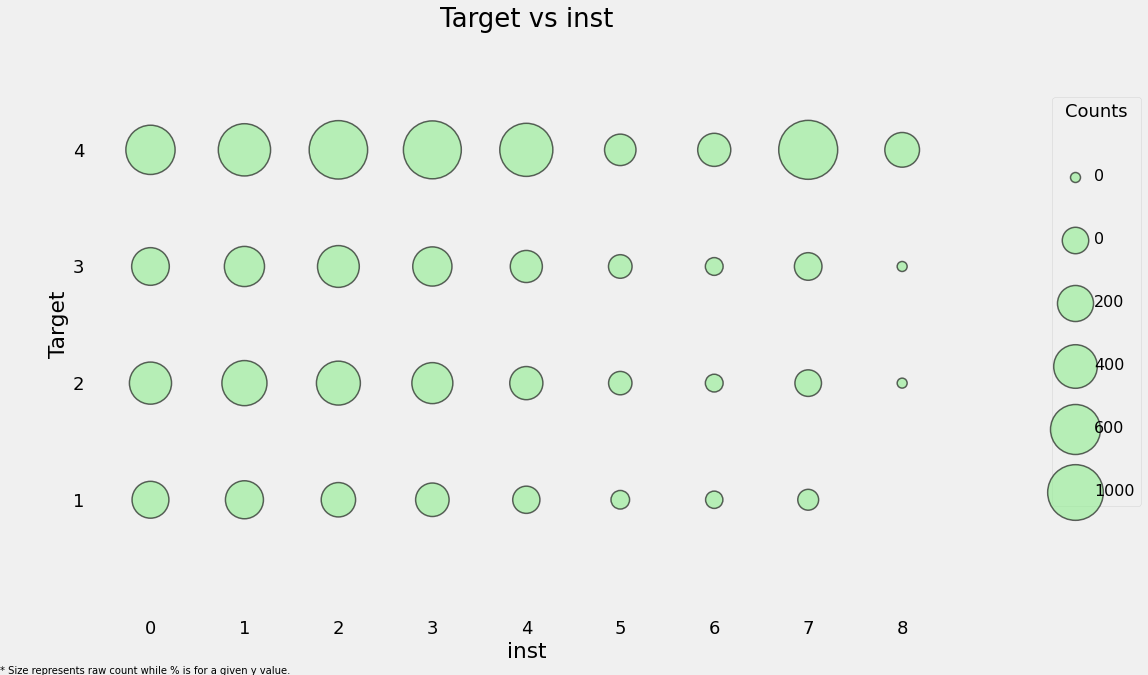

In [85]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis=1)

plot_categoricals('inst', 'Target', ind, annotate=False)

Higher levels of education seem to correspond to less extreme levels of poverty. We do need to keep in mind this is on an individual level through and we eventually will have to aggregate this data at the household level.

Text(0.5, 1.0, 'Education Distribution by Target')

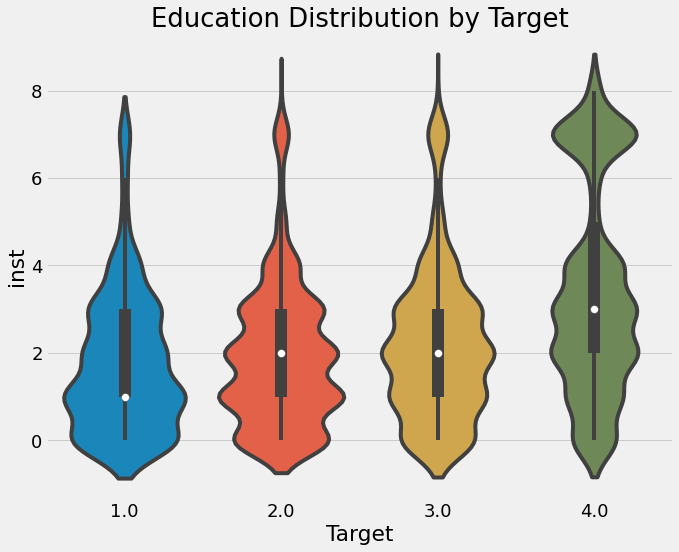

In [86]:
plt.figure(figsize=(10, 8))
sns.violinplot(x='Target', y='inst', data=ind)
plt.title('Education Distribution by Target')

In [87]:
ind.shape

(33413, 40)

### Feature Construction

We can make a few features using the existing data. For example, we can divide the years of schooling by the age.

<AxesSubplot:xlabel='Target', ylabel='escolari/age'>

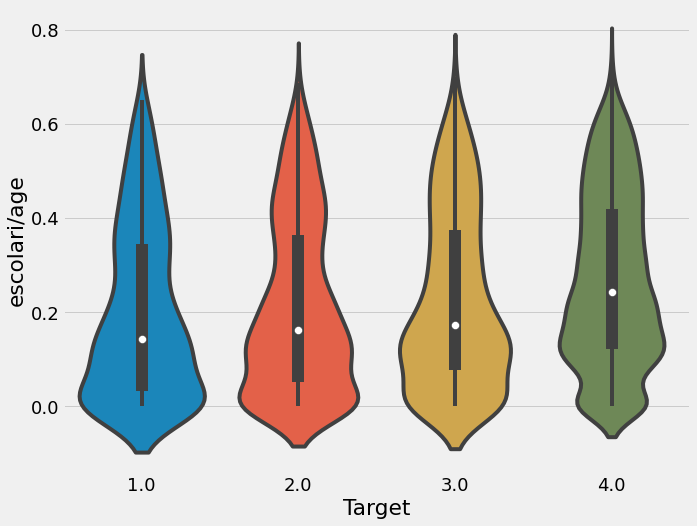

In [88]:
ind['escolari/age'] = ind['escolari'] / ind['age']

plt.figure(figsize=(10, 8))
sns.violinplot('Target', 'escolari/age', data=ind)

We can also take our new variable, inst, and divide this by the age. The final variable we'll name tech: this represents the combination of tablet and mobile phones.

In [89]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']
ind['tech'].describe()

count    33413.000000
mean         1.214886
std          0.462567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: tech, dtype: float64

## Feature Engineering through Aggregations

In order to incorporate the individual data into the household data, we need to aggregate it for each household. The simplest way to do this is to groupby the family id idhogar and then agg the data. For the aggregations for ordered or continuous variables, we can use six, five fo which are built in to pandas, and one of which we define ourselves range_. The boolean aggregations can be the same, but this will create many redundant columns which we will then need to drop. For this case, we'll use the same aggregations and then go back and drop the redundant columns.

In [98]:
ind.drop(columns='Target').iloc[:, 1:]

,idhogar,v18q,dis,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,mobilephone,rez_esc-missing,rez_esc,escolari,age,inst,escolari/age,inst/age,tech
0,21eb7fcc1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,False,0.0,10,43,3,0.232558,0.069767,1
1,0e5d7a658,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,False,0.0,12,67,7,0.179104,0.104478,2
2,2c7317ea8,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,0.0,11,92,4,0.119565,0.043478,0
3,2b58d945f,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,False,1.0,9,17,3,0.529412,0.176471,2
4,2b58d945f,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,False,0.0,11,37,4,0.297297,0.108108,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33408,3aa78c56b,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,False,0.0,3,10,1,0.300000,0.100000,1
33409,d237404b6,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,False,0.0,6,54,2,0.111111,0.037037,1
33410,d237404b6,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,False,1.0,4,12,1,0.333333,0.083333,1
33411,d237404b6,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,False,0.0,5,12,1,0.416667,0.083333,1


In [99]:
# define custom fuction
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# group and aggregate
ind_agg = ind.drop(columns='Target').iloc[:, 1:].groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                                 \
           min max sum count  std range_ min max sum count       std range_   
idhogar                                                                       
000a08204    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  0.707107      1   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  0.000000      0   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   

          female                                estadocivil1                \
             min max sum count       std range_          min max sum count   
idhogar                                                                      
000a08204      0   1   1     3  0.577350      1            0   1   1     3   
000bce7c4      0   1   1     2  0.707107      1            0   0   0     2   
001845fb0      0   1   2     4  0.577350      1            0   0   0     4   
001ff74ca      1   1   2     2  0.000000      0            0   1   1     2   
003123ec2      0   1   1     4  0.500000      1            0   1   2     4   

                           estadocivil2                                \
                std range_          min max sum count      std range_   
idhogar                                                                 
000a08204  0.577350      1            0   1   2     3  0.57735      1   
000bce7c4  0.000000      0            0   0   0     2  0.00000      0   
001845fb0  0.000000      0            0   1   2     4  0.57735      1   
001ff74ca  0.707107      1            0   0   0     2  0.00000      0   
003123ec2  0.577350      1            0   1   2     4  0.57735      1   

          estadocivil3                           estadocivil4                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            1   1   2     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   0   0     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                      estadocivil5                                 \
           std range_          min max sum count       std range_   
idhogar                                                             
000a08204  0.0      0            0   0   0     3  0.000000      0   
000bce7c4  0.0      0            0   0   0     2  0.000000      0   
001845fb0  0.0      0            0   0   0     4  0.000000      0   
001ff74ca  0.0      0            0   1   1     2  0.707107      1   
003123ec2  0.0      0            0   0   0     4  0.000000      0   

          estadocivil6                           estadocivil7                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            0   0   0     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   1   2     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                          parentesco1                                 \
               std range_         min max sum count       std range_   
idhogar                                                                
000a08204  0.00000      0           0   1   1     3  0.577350      1   
000bce7c4  0.00000      0           0   1   1     2  0.70710

With just that one line, we go from 30 features to 180. Next we can rename the columns to make it easier to keep track.

In [100]:
# rename the columns
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')

ind_agg.columns = new_col
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,dis-std,dis-range_,female-min,female-max,female-sum,female-count,female-std,female-range_,estadocivil1-min,estadocivil1-max,estadocivil1-sum,estadocivil1-count,estadocivil1-std,estadocivil1-range_,estadocivil2-min,estadocivil2-max,estadocivil2-sum,estadocivil2-count,estadocivil2-std,estadocivil2-range_,estadocivil3-min,estadocivil3-max,estadocivil3-sum,estadocivil3-count,estadocivil3-std,estadocivil3-range_,estadocivil4-min,estadocivil4-max,estadocivil4-sum,estadocivil4-count,estadocivil4-std,estadocivil4-range_,estadocivil5-min,estadocivil5-max,estadocivil5-sum,estadocivil5-count,estadocivil5-std,estadocivil5-range_,estadocivil6-min,estadocivil6-max,estadocivil6-sum,estadocivil6-count,estadocivil6-std,estadocivil6-range_,estadocivil7-min,estadocivil7-max,estadocivil7-sum,estadocivil7-count,estadocivil7-std,estadocivil7-range_,parentesco1-min,parentesco1-max,parentesco1-sum,parentesco1-count,parentesco1-std,parentesco1-range_,parentesco2-min,parentesco2-max,parentesco2-sum,parentesco2-count,parentesco2-std,parentesco2-range_,parentesco3-min,parentesco3-max,parentesco3-sum,...,instlevel5-count,instlevel5-std,instlevel5-range_,instlevel6-min,instlevel6-max,instlevel6-sum,instlevel6-count,instlevel6-std,instlevel6-range_,instlevel7-min,instlevel7-max,instlevel7-sum,instlevel7-count,instlevel7-std,instlevel7-range_,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-count,instlevel8-std,instlevel8-range_,instlevel9-min,instlevel9-max,instlevel9-sum,instlevel9-count,instlevel9-std,instlevel9-range_,mobilephone-min,mobilephone-max,mobilephone-sum,mobilephone-count,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,rez_esc-sum,rez_esc-count,rez_esc-std,rez_esc-range_,escolari-min,escolari-max,escolari-sum,escolari-count,escolari-std,escolari-range_,age-min,age-max,age-sum,age-count,age-std,age-range_,inst-min,inst-max,inst-sum,inst-count,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-count,escolari/age-std,escolari/age-range_,inst/age-min,inst/age-max,inst/age-sum,inst/age-count,inst/age-std,inst/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,0.000000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,2,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.000000,0,0,0,0,3,0.0,0,0,0,0,3,0.00000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,1,...,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,1,2,3,0.577350,1,0,0,0,3,0.0,0,1,1,3,3,0.0,0,0.0,0.0,0.0,3,0.0,0.0,0,14,26,3,7.571878,14,4,30,62,3,14.468356,26,0,7,14,3,4.041452,7,0.000000,0.500000,0.900000,3,0.264575,0.500000,0.000000,0.250000,0.483333,3,0.139775,0.250000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,2,0.000000,0,0,0,0,2,0.00000,0,1,1,2,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,0,0,0,2,0.00000,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,...,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,1,1,2,2,0.0,0,0.0,0.0,0.0,2,0.0,0.0,0,5,5,2,3.535534,5,60,63,123,2,2.121320,3,0,1,1,2,0.707107,1,0.000000,0.083333,0.083333,2,0.058926,0.083333,0.000000,0.016667,0.016667,2,0.011785,0.016667,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,1,2,4,0.577350,1,0,0,0,4,0.000000,0,0,1,2,4,0.57735,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,0,0,4,0.0,0,0,1,2,4,0.57735,1,0,1,1,4,0.500000,1,0,1,1,4,0.500000,1,0,1,2,...,4,0.5,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,1,1,4,0.500000,1,0,0,0,4,0.0,0,1,1,4,4,0.0,0,0.0,0.0,0.0,3,0.0,0.0,6,14,41,4,3.304038,8,19,52,142,4,16.421531,33,2,7,16,4,2.160247,5,0.115385,0.526316,1.397906,4,0.183106,0.410931,0.038462,0.166667,0.511959,4,0.060123,0.128205,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,0.000000,0,1,1,2,2,0.000000,0,0,1,1,2,0.707107,1,0,0,0,2,0.00

In [101]:
ind_agg.iloc[:, [0, 1, 2, 3, 6, 7, 8, 9]].head()

,v18q-min,v18q-max,v18q-sum,v18q-count,dis-min,dis-max,dis-sum,dis-count
idhogar,,,,,,,,
000a08204,1,1,3,3,0,0,0,3
000bce7c4,0,0,0,2,0,1,1,2
001845fb0,0,0,0,4,0,0,0,4
001ff74ca,1,1,2,2,0,0,0,2
003123ec2,0,0,0,4,0,0,0,4


### Feature Selection

As a first round of feature selection, we can remove one out for every pair of variables with a correlation greater than 0.95

In [103]:
# create corrlation matirx
corr_matrix = ind_agg.corr()

# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')

There are 111 correlated columns to remove.


We'll drop the columns and then marge with the heads data to create a final dataframe.

In [104]:
ind_agg = ind_agg.drop(columns=to_drop)
ind_feats = list(ind_agg.columns)

# merge on the household id
final = heads.merge(ind_agg, on='idhogar', how='left')

print('Final features shape: ', final.shape)

Final features shape:  (10307, 228)


In [105]:
final.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,eviv1,eviv2,eviv3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,...,parentesco6-max,parentesco6-sum,parentesco7-min,parentesco7-max,parentesco8-min,parentesco8-max,parentesco9-min,parentesco9-max,parentesco9-sum,parentesco10-min,parentesco10-max,parentesco11-min,parentesco11-max,parentesco11-sum,parentesco12-min,parentesco12-max,parentesco12-sum,instlevel1-min,instlevel1-max,instlevel1-sum,instlevel2-min,instlevel2-max,instlevel2-sum,instlevel2-std,instlevel3-min,instlevel3-max,instlevel3-sum,instlevel3-std,instlevel4-min,instlevel4-max,instlevel4-sum,instlevel4-std,instlevel5-min,instlevel5-max,instlevel5-sum,instlevel6-min,instlevel6-max,instlevel7-min,instlevel7-max,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-std,instlevel9-min,instlevel9-max,mobilephone-min,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_,inst-max,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-std,escolari/age-range_,inst/age-max,inst/age-std,inst/age-range_,tech-min,tech-sum,tech-std,tech-range_
0,ID_279628684,21eb7fcc1,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,190000.0,0.0,10.0,0.0,10.0,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,1,1,1,NaN,0,0,0,0,0,0,0,0,0,0,NaN,0,0,1,NaN,0,0.0,0.0,10,10,10,NaN,0,43,43,43,NaN,0,3,NaN,0,0.232558,0.232558,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0
1,ID_f29eb3ddd,0e5d7a658,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,135000.0,8.0,12.0,0.0,12.0,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,1,1,1,NaN,0,0,1,NaN,0,0.0,0.0,12,12,12,NaN,0,67,67,67,NaN,0,7,NaN,0,0.179104,0.179104,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0
2,ID_68de51c94,2c7317ea8,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,False,0.0,8.0,0.0,11.0,11.0,0.500000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,1,1,1,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0.0,0.0,11,11,11,NaN,0,92,92,92,NaN,0,4,NaN,0,0.119565,0.119565,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0
3,ID_ec05b1a7b,2b58d945f,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,180000.0,1.0,11.0,0.0,11.0,1.333333,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.5,0,0,0,0.0,0,1,1,0.5,0,1,2,0,0,0,0,0,0,0,0.0,0,0,1,0.0,0,0.0,1.0,2,11,33,4.272002,9,8,38,100,14.899664,30,4,1.414214,3,0.250000,0.529412,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0
4,ID_1284f8aad,d6dae86b7,4.0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,130000.0,1.0,9.0,0.0,10.0,4.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0.5,0,0,0,0.0,0,1,1,0.5,0,1,1,0,0,0,0,0,0,0,0.0,0,0,1,0.0,0,0.0,1.0,0,11,23,5.123475,11,7,30,76,11.690452,23,4,1.825742,4,0.000000,0.392857,0.965584,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0


### Final Data Exploration

We'll do a little bit of exploration.

In [106]:
corrs = final.corr()['Target']

In [107]:
corrs.sort_values().head()

warning          -0.301791
instlevel2-sum   -0.297868
instlevel1-sum   -0.271204
hogar_nin        -0.266309
r4t1             -0.260917
Name: Target, dtype: float64

In [108]:
corrs.sort_values().dropna().tail()

walls+roof+floor    0.332446
meaneduc            0.333652
inst-max            0.368229
escolari-max        0.373091
Target              1.000000
Name: Target, dtype: float64

We can see some of the variables that we made are highly correlated with the Target. Whether these variables are actually useful will be determined in the modeling stage.

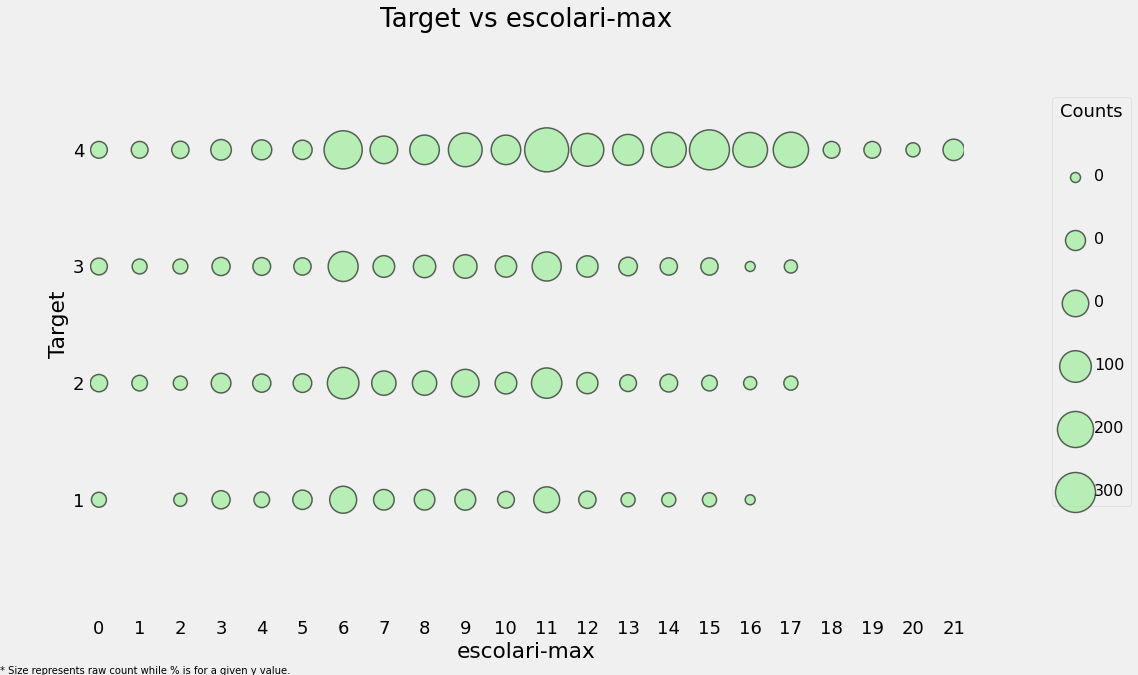

In [109]:
plot_categoricals('escolari-max', 'Target', final, annotate=False)

Text(0.5, 1.0, 'Max Schooling by Target')

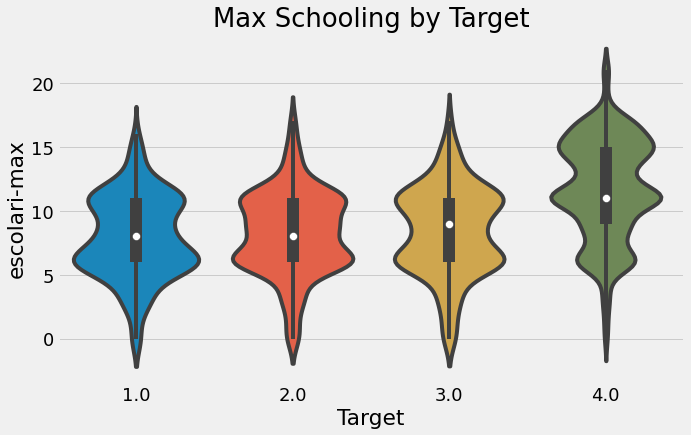

In [110]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Target', y='escolari-max', data=final)
plt.title('Max Schooling by Target')

Text(0.5, 1.0, 'Max Schooling by Target')

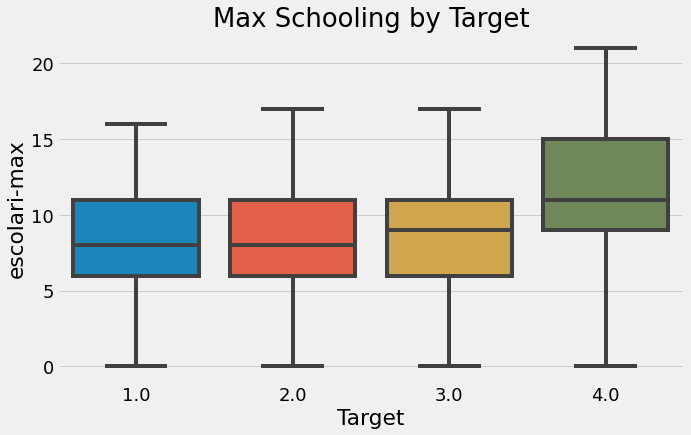

In [111]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='escolari-max', data=final)
plt.title('Max Schooling by Target')

Text(0.5, 1.0, 'Average Schooling by Target')

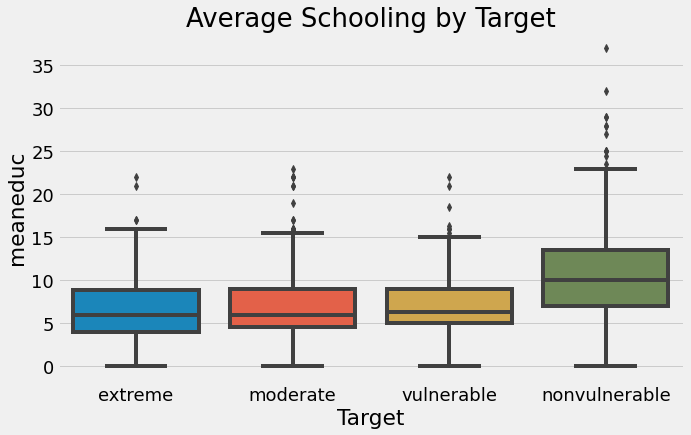

In [112]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='meaneduc', data=final)
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Average Schooling by Target')

Text(0.5, 1.0, 'Overcrowding by Target')

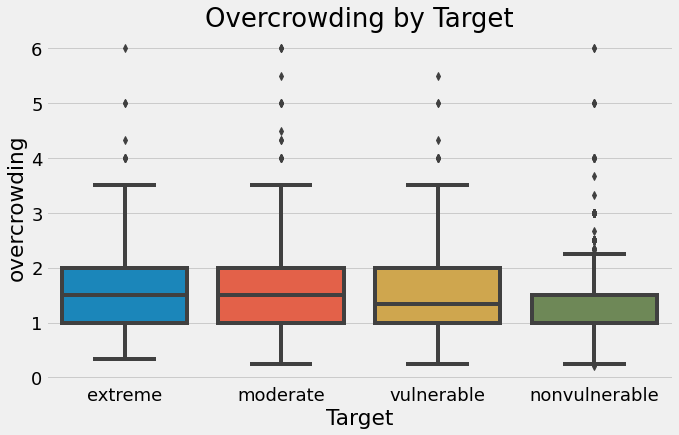

In [113]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='overcrowding', data=final)
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Overcrowding by Target')

One other feature that might be useful is the greater of the head of household. Since we aggregated the data, we'll have to go back to the individual level data and final the gender for the head of household.

In [114]:
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final = final.merge(head_gender, on='idhogar', how='left').rename(columns={'female': 'female-head'})

In [115]:
final.groupby('female-head')['Target'].value_counts(normalize=True)

female-head  Target
0            4.0       0.682873
             2.0       0.136464
             3.0       0.123204
             1.0       0.057459
1            4.0       0.617369
             2.0       0.167670
             3.0       0.113500
             1.0       0.101462
Name: Target, dtype: float64

It looks like households where the head is female are slightly more likely to have a severe level of poverty.

Text(0.5, 1.0, 'Target by Female Head of Household')

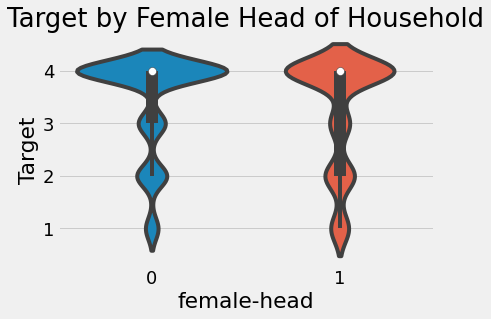

In [116]:
sns.violinplot(x='female-head', y='Target', data=final)
plt.title('Target by Female Head of Household')

We can also look at the differece in average education by whether or not the family has a female head of household.

Text(0.5, 1.0, 'Average Education by Target and Female Head of Household')

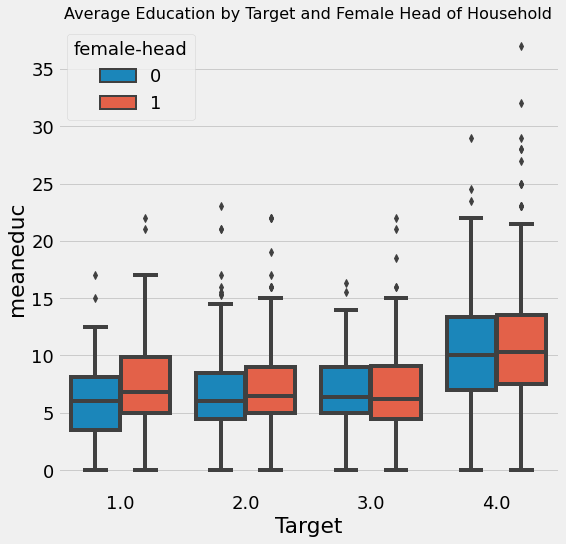

In [117]:
plt.figure(figsize=(8, 8))
sns.boxplot(x='Target', y='meaneduc', hue='female-head', data=final)
plt.title('Average Education by Target and Female Head of Household', size=16)

It looks like at every value of the Target, households with female heads have higher levels of education. Yet, we saw that overall, households with female heads are morelikely to have severe poverty.

In [118]:
final.groupby('female-head')['meaneduc'].agg(['mean', 'count'])

,mean,count
female-head,,
0,8.968025,6384
1,9.237013,3903


Overall, the average education of households with female heads is slightly higher than those with male heads. I'm not too sure what to make of this, but it semms right to me.

# Machine Learning Modeling

To first show the process of modeling, we'll use the capable Random Forest Classifier in Scikit-Learn. This probably won't get us to the top of the leaderboard, but it will allow us to establish a baseline. Later we'll try several other models including the powerful Gradient Boosting Machine.  
  
To assess our model, we'll use 10-fold cross validation on the training data. This will essentially train and test the model 10 times useing different splits of the training data. 10-fold cross validation is an effective method for estimating the performance of a model on the test set. We want to look at the average performance in cross validation as well as the standard deviation to see how much scores change between the folds. We use the F1 Macro measure to evaluate performance.

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average='macro')

In [120]:
# labels for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# extract the training data
train_set = final[final['Target'].notnull()].drop(columns=['Id', 'idhogar', 'Target'])
test_set = final[final['Target'].isnull()].drop(columns=['Id', 'idhogar', 'Target'])

# submission base which is used for making submissions to the competition
submission_base = test[['Id', 'idhogar']].copy()

Because we are going to be comparing different models, we want to sclae the features (limit the range of each column to between 0 and 1). For many ensemble models that is not necessary, but when we use models that depend on a distance metric, such as KNearest Neighbors or the Support Vector Machine, feature scaling is an absolute necessity. When comparing different models, it's always safest to scale the features. We also impute the missing values with the median of the feature.  
  
For imputing missing values and scling the features in one step, we can make a pipeline. This will be fit on the training data and used to transform the training and testing data.

In [121]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler())])

# fit and transform training data
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

The data has no missing values and is scaled between aero and one. This means it can be directly used in any Scikit-Learn model.

In [123]:
model = RandomForestClassifier(n_estimators=100, random_state=10, n_jobs=-1)

# 10 fold cross validation
cv_score = cross_val_score(model, train_set, train_labels, cv=10, scoring=scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3439 with std = 0.0438


That score is not great, but it will serve as a baseline and leaves us plenty of room to imporve.

## Feature Importances

With a tree-based model, we can look at the feature importances which show a relative ranking of the usefullness of features in the model. These represent the sum of the reduction in impurity at nodes that used the variable for splitting, but we don't have to pay much attention to the absolute value. Instead we'll focus on relative scores.  
  
If we want to view the feature importances, we'll have to train a model on the whole training set. Cross validation does not return the feature importances.

In [124]:
model.fit(train_set, train_labels)

# feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

,feature,importance
0,hacdor,0.000643
1,hacapo,0.000283
2,v14a,0.000460
3,refrig,0.001798
4,paredblolad,0.006024


Below is a short function we'll use to plot the feature importances. I use this function a lot and often copy and paste it between scripts.

In [139]:
def plot_feature_importances(df, n=10, threshold=None):
    plt.style.use('fivethirtyeight')

    # sort features with most important at the head
    df = df.sort_values('importance', ascending=False).reset_index(drop=True)

    # normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    plt.rcParams['font.size'] = 12

    # bar plot of n most important features
    df.loc[:n, :].plot.barh(y='importance_normalized', x='feature', color='darkgreen', edgecolor='k', figsize=(12, 8), legend=False, linewidth=2)

    plt.xlabel('Normalized Importance', size=18)
    plt.ylabel('')
    plt.title(f'{n} Most Important Features', size=18)
    plt.gca().invert_yaxis()

    if threshold:
        # cumulative importance plot
        plt.figure(figsize=(8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size=16)
        plt.ylabel('Cumulative Importance', size=16)
        plt.title('Cumulative Feature Importance', size=18)

        # number of features needed for threshold cumulative importance
        # this is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))

        # add vertical line to plot
        plt.vlines(importance_index + 1, ymin=0, ymax=1.05, linestyles='--', colors='red')
        plt.show()

        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 100 * threshold))

    return df

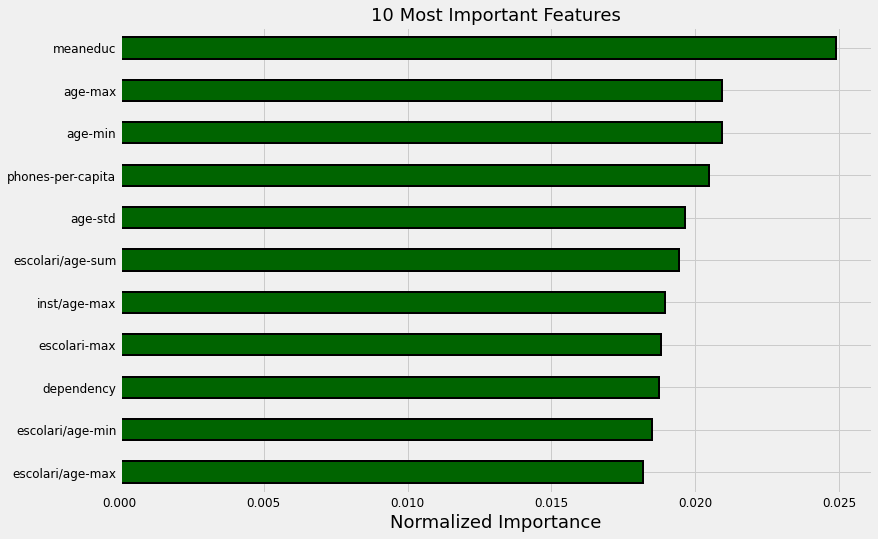

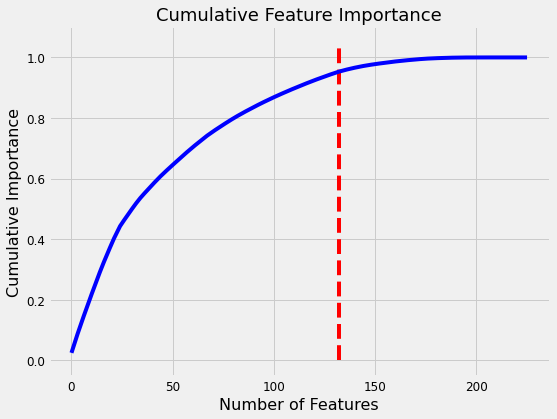

132 features required for 95% of cumulative importance.


In [140]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

The most important variable is the average amount of education in the household, followed by the maximum education of anyone in the household. I have a suspicion these variables are highly correlated (collinear) which means we may want to remove one of them from the data. The other most important features are a combination of variables we created and variables that were already presnet in the data.  
  
It's interesting that we only need 106 of the ~180 features to account for 90% of the importance. This tell us that we may be able to remove some of the features. However, feature importances dont't tell us which direction of the feature is important (for example, we cant't use these to tell whether more or less education leads to more severe poverty) they only tell us which features the model considered relevant.

In [143]:
def kde_target(df, variable):
    colors = {1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}

    plt.figure(figsize=(12, 8))

    df = df[df['Target'].notnull()]

    for level in df['Target'].unique():
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), label=f'Poverty Level: {level}', color=colors[int(subset['Target'].unique())])

    plt.xlabel(variable)
    plt.ylabel('Density')
    plt.legend()
    plt.title('{} Distribution'.format(variable.capitalize()))

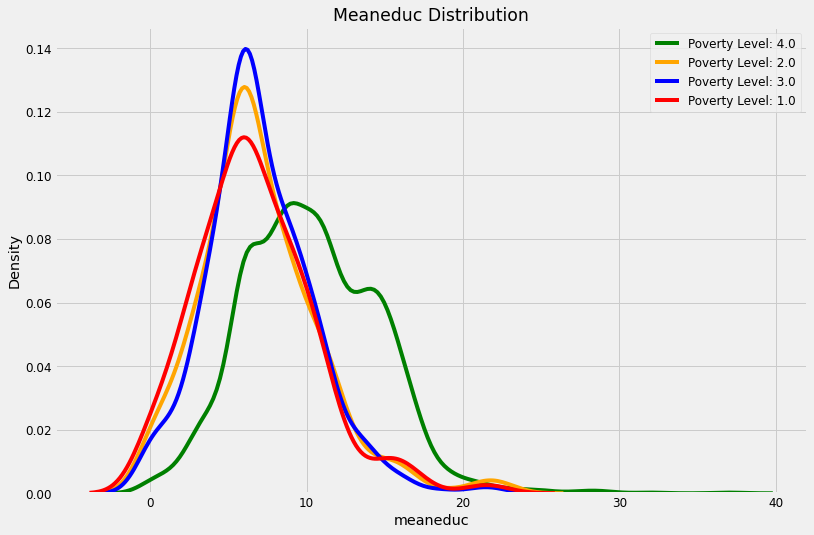

In [144]:
kde_target(final, 'meaneduc')

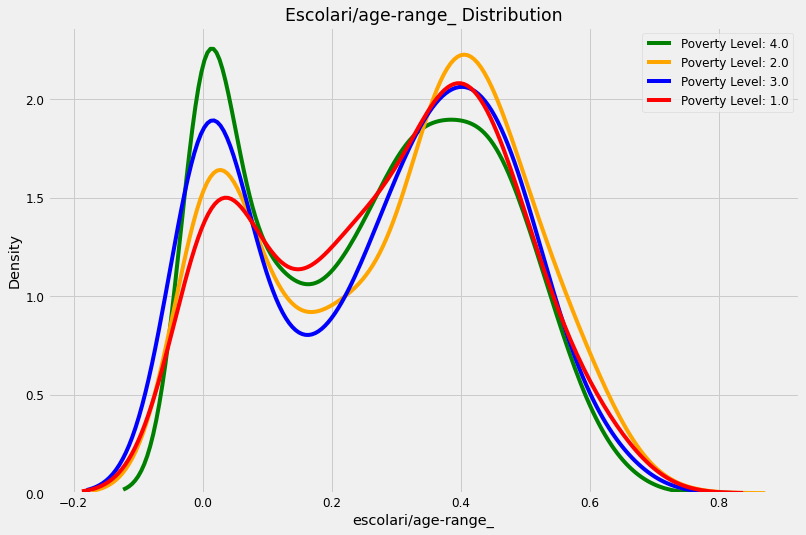

In [145]:
kde_target(final, 'escolari/age-range_')

# Model Selection

We already tried one basic model, the Random Forest Clssifier which delivered a best macro F1 of 0.35. However, in machine learning, there is no way to know ahead of time which model will work best for a given dataset. The following plot shows that **there are some problems where even Gaussian Naive Bays will outperform a gradient boosting machine.** This is from [an excellent paper by Randal Olson that discusses many points of machin learning.](https://psb.stanford.edu/psb-online/proceedings/psb18/olson.pdf)  
  
![Alt text](./heatmap%20for%20modeling.png)

What this plot tells us is that we have to try out a number of different models to see which is optimal. Most people eventually settle on the **gradient boosting machine** and we will try that out, but for now we'll take a look at some of the other options. There are literally dozens (maybe hundreds) of multi-class machine learning models if we look at the Scikit-Learn documentation. We don't have to try them all, but we should sample from the options.  
  
What we want to do is write a function that can evaluate a model. This will be pretty simple since we already wrote most of the code. In addition to the Random Forest Classifier, we'll try eight other Scikit-Learn models. Luckily, this dataset is relatively small and we can rapidly iterate through the models. We will make a dataframe to hold the results and the function will add a row to the dataframe for each model.

In [149]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import ConvergenceWarning

# filter out warnings from model
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore')

In [147]:
# dataframe to hold results
model_results = pd.DataFrame(columns=['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    '''Perform 10 fold cross validation of a model'''

    cv_scores = cross_val_score(model, train, train_labels, cv=10, scoring=scorer, n_jobs=-1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')

    if model_results is not None:
        model_results = model_results.append(
            pd.DataFrame({'model': name, 'cv_mean': cv_scores.mean(), 'cv_std': cv_scores.std()}, index=[0]), ignore_index=True)
        
        return model_results

In [150]:
model_results = cv_model(train_set, train_labels, LinearSVC(), 'LSVC', model_results)

/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_b

10 Fold CV Score: 0.28552 with std: 0.03985


/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/bagjaegyeong/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


That's one model to cross off the list (although we didn't perform hyperarameter tuning so the actual performance could possibly be improved).

In [151]:
model_results = cv_model(train_set, train_labels, GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.18451 with std: 0.03657


That performance is very poor. I don't think we need to revisit the Gaussian Naive Bayes method (although there are problems on which it can outperform the Gradient Boosting Machine).

In [152]:
model_results = cv_model(train_set, train_labels, MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)), 'MLP', model_results)

10 Fold CV Score: 0.30475 with std: 0.04853


The multi-layer perceptron (a deep neural network) has decent performance. This might be an option if we are able to hyperparameter tune the network. However, the limited amount of data could be an issue with a neural network as these generally require hundreds of thousands of examples to learn effectively.

In [153]:
model_results = cv_model(train_set, train_labels, LinearDiscriminantAnalysis(), 'LDA', model_results)

10 Fold CV Score: 0.31792 with std: 0.06199


If you run LinearDiscriminanAnalysis without filtering out the UserWarnings, you get many messages saying "Variables are collinear." This might give us a hint that we want to remove some collinear features. We might want to try this model again after removing the collinear variables because the score is comparable to the random forest.

In [154]:
model_results = cv_model(train_set, train_labels, RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.27803 with std: 0.0342


The linear model (with ridge regularization) does surprisingly well. This might indicate that a simple model can go a long way in this problem (although we'll probably end up using a more powerful method).

In [155]:
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_set, train_labels, KNeighborsClassifier(n_neighbors=n), f'knn-{n}', model_results)


KNN with 5 neighbors

10 Fold CV Score: 0.34765 with std: 0.03354

KNN with 10 neighbors

10 Fold CV Score: 0.31992 with std: 0.03213

KNN with 20 neighbors

10 Fold CV Score: 0.30723 with std: 0.04762


As one more attempt, we'll consider the ExtraTreesClassifier, a variant on the random forest using ensembles of decision trees as well.

In [156]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_set, train_labels, ExtraTreesClassifier(n_estimators=100, random_state=10), 'EXT', model_results)

10 Fold CV Score: 0.32681 with std: 0.05096


## Comparing Model Performance

With the modeling results in a dataframe, we can plot them to see which model does the best.

In [157]:
model_results = cv_model(train_set, train_labels, RandomForestClassifier(100, random_state=10), 'RF', model_results)

10 Fold CV Score: 0.34394 with std: 0.04381


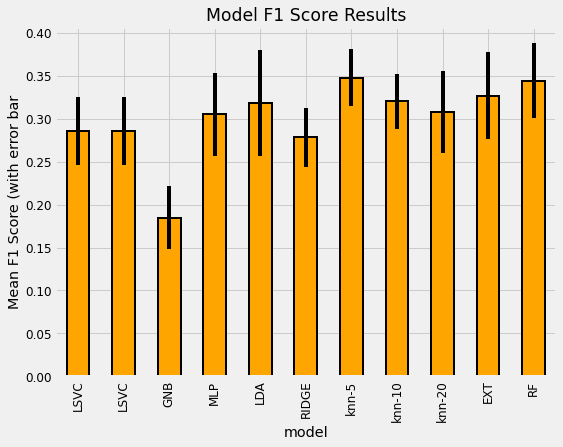

In [158]:
model_results.set_index('model', inplace=True)
model_results['cv_mean'].plot.bar(color='orange', figsize=(8, 6), yerr=list(model_results['cv_std']), edgecolor='k', linewidth=2)
plt.title('Model F1 Score Results')
plt.ylabel('Mean F1 Score (with error bar')
model_results.reset_index(inplace=True)

(LSVC 때 warning 조정하느라 두 번 돌려서 값이 두 개 들어갔다;;)  
  
The most likely candidate seems to be the Random Forest because it does best right out of the box. ??? While we didn't tune any of the hyperparameters so the comparison between models is not perfect, these results reflect those of many other Kaggle competitiors finding that tree-based ensemble methods (including the Gradient Boosting Machine) perform very well on structured datasets. Hyperparameter performance does imporve the performance of machine learning models, but we don't have time to try all possible combinations of settings for all models. The graph below shows the effect of hyperparameter tuning versus the default values in Sckit-Learn.  
  
![Alt text](./hyperparameter_improvement.png)

In most cases that accuracy gain is less than 10% so the worst model is probably not suddenly going to become the best model through tuning.  
  
For now we'll say the random forest does the best. Later we'll look at using the Gradient Boosting Machine, although not implemented in Scikit-Learn. Instead we'll be using the more powerful LightGBM version. Now, let's turn to making a submission using the random forest.

## Making a Submission

The format of a testing submission is shown below. Although we are making predictions for each household, we actually need one row per individual (identified by the Id) but only the prediction for the head of household is scored.  
  
The submission_base will have all the individuals in the test set since we have to have a 'prediction' for each individual while the test_ids will only contain the idhogar from the heads of households. When predicting, we only predict for each household and then we merge the predictions dataframe with all of the individuals on the household id (idhogar). This will set the Target to the same value for everyone in a household. For the test households without a head of household, we can just set these predictions to 4 since they will not be scored.

In [159]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

In [160]:
def submit(model, train, train_labels, test, test_ids):
    # train on the data
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'idhogar': test_ids, 'Target': predictions})

    # make a submission dataframe
    submission = submission_base.merge(predictions, on='idhogar', how='left').drop(columns=['idhogar'])

    # fill in households missing a head
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)

    return submission

In [161]:
rf_submission = submit(RandomForestClassifier(n_estimators=100, random_state=10, n_jobs=-1), train_set, train_labels, test_set, test_ids)

rf_submission.to_csv('rf_submission.csv', index=False)

필자는 제출 했을 때 0.370을 받았다고 한다. (현재는 kernel-only competition 이다.)

# Feature Selection

For feature selection in this notebook, we'll first remove any columns whith greater than 0.95 correlation (we already did some of this during feature engineering) and then we'll apply recursive feature elimination with the Scikit-Learn library.  
  
First up are the corrleatins. 0.95 is an arbitrary threshold - feel free to change the values and see how the performance changes.

In [163]:
train_set = pd.DataFrame(train_set, columns=features)

# create correlation matrix
corr_matrix = train_set.corr()

# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'elec', 'v18q-count', 'female-sum']

In [164]:
train_set = train_set.drop(columns=to_drop)
train_set.shape

(2973, 222)

In [165]:
test_set = pd.DataFrame(test_set, columns=features)
train_set, test_set = train_set.align(test_set, axis=1, join='inner')
features = list(train_set.columns)

### Recursive Feature Elimination with Random Forest

The RFECV in Sklearn for Recursive Feature Elimination with Cross Validatino. The selector operates using a model with feature importances in an iterative manner. At each iteration, it removes either a fraction of features or a set number of features. The iterations continue until the cross validation score no longer improves.  
  
To create the selector object, we passes in the model, the number of features to remove at each iteration, the cross validation folds, our custom scorer, and any other parameters to guide the selection.

In [166]:
from sklearn.feature_selection import RFECV

# create a model for feature selection
estimator = RandomForestClassifier(random_state=10, n_estimators=100, n_jobs=-1)

# crate the object
selector = RFECV(estimator, step=1, cv=3, scoring=scorer, n_jobs=-1)

Then we fit the selector on the training data as with any other sklearn model. This will continue the feature selection until the cross validation scores no longer improve.

In [167]:
selector.fit(train_set, train_labels)

RFECV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=10),
      n_jobs=-1, scoring=make_scorer(f1_score, average=macro))

We can investigate the object to see the training scores for each iteration. The following code will plot the validation scores versus the number of features for the training.

169

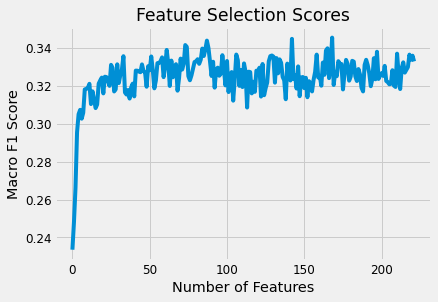

In [169]:
plt.plot(selector.grid_scores_)

plt.xlabel('Number of Features')
plt.ylabel('Macro F1 Score')
plt.title('Feature Selection Scores')
selector.n_features_

(원본 커널과는 다르게(원본 커널은 n_features_ 58) 169개가 나왔다.)  
  
We can see that the score improves as we add features up until 96 features. According to the selector, this is the optimal number of features  
  
The rankings of each feature can be found by inspecting the trained object. These represent essentially the importance of features averaged over the iterations. Features can share the same ranking, and only features with a rank of 1 are retained.

In [170]:
rankings = pd.DataFrame({'feature': list(train_set.columns), 'rank': list(selector.ranking_)}).sort_values('rank')
rankings.head(10)

,feature,rank
110,female-range_,1
124,estadocivil5-sum,1
125,estadocivil6-min,1
126,estadocivil6-max,1
127,estadocivil7-min,1
128,estadocivil7-max,1
129,estadocivil7-sum,1
130,estadocivil7-std,1
133,parentesco1-std,1
135,parentesco2-max,1


Finally, we select the features and then evaluate in cross validation.

In [171]:
train_selected = selector.transform(train_set)
test_selected = selector.transform(test_set)

In [172]:
# convert back to dataframe
selected_features = train_set.columns[np.where(selector.ranking_ == 1)]
train_selected = pd.DataFrame(train_selected, columns=selected_features)
test_selected = pd.DataFrame(test_selected, columns=selected_features)

In [173]:
model_results = cv_model(train_selected, train_labels, model, 'RF-SEL', model_results)

10 Fold CV Score: 0.35016 with std: 0.04098


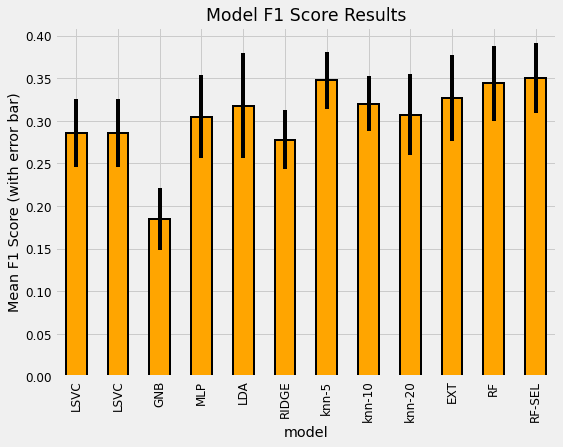

In [174]:
model_results.set_index('model', inplace=True)
model_results['cv_mean'].plot.bar(color='orange', figsize=(8, 6), yerr=list(model_results['cv_std']), edgecolor='k', linewidth=2)
plt.title('Model F1 Score Results')
plt.ylabel('Mean F1 Score (with error bar)')
model_results.reset_index(inplace=True)

??? selctor 부분 다시 보기

The model with selected features does slightly better in cross-validation. We can keep both sets of features for use in our next model, the Gradient Boosting Machine.  
  
(컴퓨터 사양의 문제로 Gradient Boosting Machine, LightGBM은 생략한다.)  
(아래는 공부할 거리만 적어두는 걸로)

# Model Optimization

Model optimization is the process of extracting the best performance from a machine learning model by tuning the hyperparameters through cross-validation. This is necessary because the best model hyperparameters are different for every dataset.  
  
In this notebook, we won't get too far into model tuning, but there are multiple options:
1. Manual
2. Grid Search
3. Random Search
4. Automated Optimization  
  
We will stick to 4 because it is generally the most efficient method and can easily be implemented in a number of libraries, including Hyperopt, which uses a modified version of Bayesian Optimization with the Tree Paraen Estimator.

## Model Tuning with Hyperopt

Bayesian optimization requires 4 parts:
1. Objective function: what we want to maximize (or minimize)
2. Domain space: region over which to search
3. Algorithm for choosing next hyperparameters: uses past results to suggest next values
4. Results history: saves the past results
  
I've written previously about using Hyperopt, so here we'll stick to the implementation.

In [176]:
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from hyperopt.pyll.stochastic import sample

In [177]:
import csv
import ast
from timeit import default_timer as timer

### 1. Objective Function

This takes in the model hyperparameters and returns the associated validation score.  
Hyperopt needs a score to minimize, so we return 1 - Macro F1 score.  
(아래 함수는 LightGBM에 맞춰진 함수로, 나중에 공부를 위해 필사 진행)

In [178]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

In [ ]:
def objective(hyperparameters, nfolds=5):
    
    # keep track of evals
    global ITERATION
    ITERATION += 1

    # retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    subsample_freq = hyperparameters['boosting_type'].get('subsample_freq', 0)

    boosting_type = hyperparameters['boosting_type']['boosting_type']

    if boosting_type == 'dart':
        hyperparameters['drop_rate'] = hyperparameters['boosting_type']['drop_rate']

    # subsample and subsample frequency to top level keys
    hyperparameters['subsample'] = subsample
    hyperparameters['subsample_freq'] = subsample_freq
    hyperparameters['boosting_type'] = boosting_type

    # whether or not to use limit maximum depth
    if not hyperparameters['limit_max_depth']:
        hyperparameters['max_depth'] = -1

    # make sure parameters that need to be integers are integers
    for parameter_name in ['max_depth', 'num_leaves', 'subsample_for_bin', 'min_child_samples', 'subsample_freq']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits=nfolds, shuffle=True)

    # convert to arrays for indexing
    features = np.array(train_selected)
    labels = np.array(train_labels).reshape((-1))

    valid_scores = []
    best_estimators = []
    run_times = []

    model = lgb.LGBMClassifier(**hyperparameters, class_weight='balanced', n_jobs=-1, metric='None', n_estimators=10000)

    # iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):

        # training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]

        start = timer()

        # train with early stopping
        # macor_f1_score: 생략한 부분에 나오는 early stopping을 위한 함수
        model.fit(
            X_train, y_train, early_stopping_rounds=100, eval_metric=macro_f1_score, eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_names=['train', 'valid'], verbose=400)
        end = timer()
        
        # record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        best_estimators.append(model.best_iteration_)

        run_times.append(end-start)
    
    score = np.mean(valid_scores)
    score_std = np.std(valid_scores)
    loss = 1 - score

    run_time = np.mean(run_times)
    run_time_std = np.std(run_times)

    estimators = int(np.mean(best_estimators))
    hyperparameters['n_estimators'] = estimators

    # write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, score, score_std])
    of_connection.close()

    # display progress
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {round(score, 4)}.')

    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteraton': ITERATION, 'time': run_time, 'time_std': run_time_std, 'status': STATUS_OK, 'score': score, 'score_std': score_std}
    

### 2. Search Space

The domain is the entrie range of values over which we want to search. The only difficult part is the subsample ratio which must be set to 1.0 if the boosting_type='goss'. Fell free to play around with the values here.

### 3. Algorithm

The algorithm for choosing the next values is the Tree Parazen Estimator which uses Bayes rule for constructing a surrogate model of the objective function. Instead of maximizing the objective function, the algorithm maximizes the Expected Imporvement(EI) of the surrogate model.

### 4. Results History

We'll use two different methods for recording results:
1. Trials object: stores everything returned from the objective function
2. Write to a csv file on every iteration
  
I like using multiple methods for tracking progress because it means redundancy. One way may fail, but hopefully both will not. The csv file can be used to monitor the method while it is runnig and the Trials object can be saved and then reloaded to resume optimization.

# Our Path

1. Understand the problem
  
2. Exploratory Data Analysis
- Deal with data issue
- Fill in missing values  
  
3. Feature Engineering
- Aggregate data
- Feature selection in stages  
  
4. Model Selection
- Try many different models for see which one is most promising
- Feature selection can also come into play
  
5. Model Optimization
- Choose the best performing model and tune
  
6. Implementing best model
  
7. Investigate predictions
  
8. Try new techniques
- Experiment and learn

(여기서 4번 - 그 중에서도 GBM 들어가기 전까지 진행함)